In [ ]:
#Imports and paths

import os
import subprocess

# Paths
working_directory="/Users/katherineridley/APPFIRE_image"
Lifs = os.path.join(working_directory, "Lifs")
OMETIFFs = os.path.join(working_directory, "OMETIFFs")
MaxPTIFFs = os.path.join(working_directory, "MaxProjections")


#download bftools onto your machine, point to bfconvert here:
bfconvert_path = "/Users/katherineridley/Downloads/bftools/bfconvert" 



In [ ]:
#convert Lifs to Tiffs
# Works with TWO channel images, splits them into separate stacks, saves as c0 and c1

# Create the output directory if it doesn't exist
if not os.path.exists(OMETIFFs):
    os.makedirs(OMETIFFs)

# Iterate through all .lif files in the input directory
for filename in os.listdir(Lifs):
    if filename.endswith(".lif"):
        input_file = os.path.join(Lifs, filename)
        

        # Loop through each series and channel
        
        for channel in [0, 1]:
                output_file = os.path.join(OMETIFFs, "%n_c{}.ome.tiff".format(channel))
                command = f"{bfconvert_path} -noflat -channel {channel} {input_file} {output_file}"
                subprocess.run(command, shell=True)

In [ ]:
#Create Max Projections, create merged file for Max Projections for TWO CHANNELS ONLY

if not os.path.exists(MaxPTIFFs):
    os.makedirs(MaxPTIFFs)

processed_files = {}  # To keep track of processed files for merging

# Loop through all .ome.tiff files in the input directory
for filename in os.listdir(OMETIFFs):
    if filename.endswith(".ome.tiff"):
        # Splitting filename to get base name and channel
        parts = filename.split('_')
        channel = parts[-1] 
        c = channel.split('.')[0]
        #print(c, 'here is channel') # Assuming channel is the second last element
        base_name = '_'.join(parts[:-1])
        
        image_path = os.path.join(OMETIFFs, filename)
        output_path = os.path.join(MaxPTIFFs, f"{base_name}_{c}_maxp.ome.tiff")

        process_image(image_path, output_path)

        # Store the output paths for merging
        if base_name not in processed_files:
            processed_files[base_name] = {}
        processed_files[base_name][c] = output_path
            
#print(processed_files)
# Merge channels for each base image
for base_name, channels in processed_files.items():
    #print('both together at merge', base_name, channels)
    if 'c0' in channels and 'c1' in channels:
        
        merge_channels(channels['c0'], channels['c1'], 
                       os.path.join(MaxPTIFFs, f"{base_name}_maxp_merge.ome.tiff"))

In [ ]:
from skimage.measure import label, regionprops
import numpy as np
import h5py
import skimage.io as io
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_fill_holes
import matplotlib.pyplot as plt
import os
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
from matplotlib.colors import ListedColormap
from skimage import io, exposure, data
from skimage.filters import gaussian
from skimage.filters import threshold_local
from skimage.filters import try_all_threshold
from skimage.filters import threshold_yen, sobel, threshold_isodata, threshold_multiotsu
import napari
import pandas as pd
from skimage.segmentation import find_boundaries
from napari.utils import nbscreenshot
import imageio

metadata = pd.read_csv('/Users/katherineridley/APPFIRE_image/TIFFs/metadata.csv')
allocproperties=[]
allmproperties=[]
ocproperties = []
mproperties=[]

folder_path = '/Users/katherineridley/APPFIRE_image/TIFFs/ProcessedImages/A_4_M04_OC_P+_CA1_011123_1.tif/mask_window_stacks'

input = '/Users/katherineridley/APPFIRE_image/TIFFs/ProcessedImages/'

thelist = os.listdir(input)[6:]

for path in thelist:
    if path.endswith('.tif'):
        imageinput = os.path.join(input, path, 'mask_window_stacks_filled/')

        print(path)

    # Separate the images according to their protein stain (OC and Methoxy-0-4)
        oc_stacks = []
        methoxy_stacks = []

        # Sort and stack the images


        for filename in sorted(os.listdir(imageinput)):
            if filename.endswith(".tif") or filename.endswith(".tiff"):
                full_path = os.path.join(imageinput, filename)
                # Load the image
                image = io.imread(full_path)
                #print(image)
                # Append the image to the corresponding stack list
                if "OC" in filename:
                    oc_stacks.append(image)
                elif "Methoxy-0-4" in filename:
                    methoxy_stacks.append(image)

        # Convert lists to 3D numpy arrays (stack them along the first axis)
        oc_stack_array = np.stack(oc_stacks, axis=0)
        methoxy_stack_array = np.stack(methoxy_stacks, axis=0)

        with napari.gui_qt():
            viewer = napari.Viewer()
            
            # Add the labeled OC stack to Napari. Each label will be visualized with a different color.
            viewer.add_labels(oc_stack_array, name='{} - OC Labeled'.format(filename), opacity=0.6)
            
            # Add the labeled methoxy stack to Napari in the same way.
            viewer.add_labels(methoxy_stack_array, name='Methoxy Labeled', opacity=0.6)

            napari.run()

In [73]:
from skimage.measure import label, regionprops
import numpy as np
import h5py
import skimage.io as io
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_fill_holes
import matplotlib.pyplot as plt
import os
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
from matplotlib.colors import ListedColormap
from skimage import io, exposure, data
from skimage.filters import gaussian
from skimage.filters import threshold_local
from skimage.filters import try_all_threshold
from skimage.filters import threshold_yen, sobel, threshold_isodata, threshold_multiotsu
import napari
import pandas as pd
from skimage.segmentation import find_boundaries
from napari.utils import nbscreenshot
import imageio

metadata = pd.read_csv('/Users/katherineridley/APPFIRE_image/TIFFs/metadata.csv')
allocproperties=[]
allmproperties=[]
ocproperties = []
mproperties=[]

folder_path = '/Users/katherineridley/APPFIRE_image/TIFFs/ProcessedImages/A_4_M04_OC_P+_CA1_011123_1.tif/mask_window_stacks'

input = '/Users/katherineridley/APPFIRE_image/TIFFs/ProcessedImages/'

for path in os.listdir(input):
    if path.endswith('.tif'):
        imageinput = os.path.join(input, path, 'mask_window_stacks_filled/')

        print(path)

        input_path = os.path.join(input, path)

    # Separate the images according to their protein stain (OC and Methoxy-0-4)
        oc_stacks = []
        methoxy_stacks = []

        # Sort and stack the images


        for filename in sorted(os.listdir(imageinput)):
            if filename.endswith(".tif") or filename.endswith(".tiff"):
                full_path = os.path.join(imageinput, filename)
                # Load the image
                image = io.imread(full_path)
                #print(image)
                # Append the image to the corresponding stack list
                if "OC" in filename:
                    oc_stacks.append(image)
                elif "Methoxy-0-4" in filename:
                    methoxy_stacks.append(image)

        # Convert lists to 3D numpy arrays (stack them along the first axis)
        oc_stack_array = np.stack(oc_stacks, axis=0)
        methoxy_stack_array = np.stack(methoxy_stacks, axis=0)

        '''with napari.gui_qt():
            viewer = napari.Viewer()
            
            # Add the labeled OC stack to Napari. Each label will be visualized with a different color.
            viewer.add_labels(oc_stack_array, name='OC Labeled', opacity=0.6)
            
            # Add the labeled methoxy stack to Napari in the same way.
            viewer.add_labels(methoxy_stack_array, name='Methoxy Labeled', opacity=0.6)

            napari.run()

        # The arrays `oc_stack_array` and `methoxy_stack_array` now contain your stacked images for each protein

        # From here, you can directly apply your morphological analysis
        # For a simple example, we can calculate volumes of each labeled region
        def analyze_morphology(stack):
            
            properties_list = []
            for z_slice in stack:
                # Ensure that z_slice is a NumPy array using np.asarray, in case it is not already
                z_slice_array = np.asarray(z_slice)
                #print('1', z_slice_array)
                labeled_image = label(z_slice_array)
                #print('2', labeled_image)
                for region in regionprops(z_slice_array):
                    properties = {
                        'label': region.label,
                        'volume': region.area,  # The area for each 2D region
                        # ... other properties
                    }
                    properties_list.append(properties)
            return properties_list

        oc_properties = analyze_morphology(oc_stack_array)
        methoxy_properties = analyze_morphology(methoxy_stack_array)

        # Do something with the `oc_properties` and `methoxy_properties`, like saving to a DataFrame
        import pandas as pd
        oc_df = pd.DataFrame(oc_properties)
        methoxy_df = pd.DataFrame(methoxy_properties)

        # Save to CSV if needed
        oc_df.to_csv('oc_morphology.csv', index=False)
        methoxy_df.to_csv('methoxy_morphology.csv', index=False)

        def analyze_morphology(labeled_stack):
            properties = regionprops(labeled_stack)
            for prop in properties:
                volume = prop.area # In 2D, this will be the area
                length = prop.major_axis_length
                width = prop.minor_axis_length
                # For 3D, consider the 3D properties such as prop.volume if you used a 3D labeling function
                # Do something with these measurements, like saving to a DataFrame


        '''

        from skimage.measure import label, regionprops
        from skimage.morphology import cube, closing
        
        def analyze_morphology_3d(stack, name):
            # Label the 3D stack

            # Define the structuring element for connectivity (e.g., face connectivity)
            selem = cube(3)

            # Apply the closing operation to the 3D stack using the cube structuring element
            closed_stack = closing(stack, selem)

            norm_stack = closed_stack / 255

            # Label the closed 3D stack
            labeled_stack = label(closed_stack)

            norm_labeled = label(norm_stack)

            norm_labeled = norm_labeled.astype('uint64')

            

            threedpath = os.path.join(input_path, 'closed_3D_objects/')
            os.makedirs(threedpath, exist_ok=True)
            np.save(os.path.join(threedpath, f'closed_3D_labeled_{name}.npy'), labeled_stack)
            np.save(os.path.join(threedpath, f'closed_3D_{name}.npy'), closed_stack)
            np.save(os.path.join(threedpath, f'norm_closed_3D_labeled_{name}.npy'), norm_labeled)

            # Find the largest label
            largest_label = 0
            max_volume = 0
            for region in regionprops(norm_labeled):
                
                if region.area > max_volume:
                    max_volume = region.area
                    largest_label = region.label

            # Measure region properties for the largest label only
            properties = []
            for region in regionprops(norm_labeled):
                if region.label == largest_label:
                    props = {
                        'image': path,
                        'label': region.label,
                        'volume': region.area,
                        'centroid': region.centroid,
                        'extent': region.extent,
                        'axis_major': region.axis_major_length,
                        'axis_minor': region.axis_minor_length,
                        'bbox': region.bbox
                    }
                    properties.append(props)
                    break  # Only process the largest label

            return properties

        
        # Example usage:
        oc_properties_3d = analyze_morphology_3d(oc_stack_array, 'OC')
        methoxy_properties_3d = analyze_morphology_3d(methoxy_stack_array, "Methoxy")
        print(methoxy_properties_3d)
        allocproperties.extend(oc_properties_3d)

        allmproperties.extend(methoxy_properties_3d)

    # You can then use these properties as needed, possibly converting them to a DataFrame again:
import pandas as pd
oc_df_3d = pd.DataFrame(allocproperties)
methoxy_df_3d = pd.DataFrame(allmproperties)

# Save to CSV
oc_df_3d.to_csv('oc_morphology_3d_norm255_filled.csv', index=False)
methoxy_df_3d.to_csv('methoxy_morphology_3d_norm255_filled.csv', index=False)

C_1_M04_OC_DGG_P+_151123_1.tif
[{'image': 'C_1_M04_OC_DGG_P+_151123_1.tif', 'label': 1, 'volume': 71015.0, 'centroid': (10.371344082236147, 206.73315496726045, 182.26837991973528), 'extent': 0.25565931771380845, 'axis_major': 90.77794904202649, 'axis_minor': 30.815995934044444, 'bbox': (0, 150, 127, 22, 257, 245)}]
C_2_M04_OC_CA1_P+_161123_1.tif
[{'image': 'C_2_M04_OC_CA1_P+_161123_1.tif', 'label': 1, 'volume': 63920.0, 'centroid': (7.743898623279099, 212.92462453066332, 223.68102315394242), 'extent': 0.28381642512077293, 'axis_major': 113.93779664235294, 'axis_minor': 23.031767701217394, 'bbox': (0, 172, 162, 18, 264, 298)}]
B_4_M04_OC_L1_P+_131123_1.tif
[{'image': 'B_4_M04_OC_L1_P+_131123_1.tif', 'label': 1, 'volume': 317026.0, 'centroid': (11.75228845583643, 217.04530858667744, 213.88948855929797), 'extent': 0.46045896877269427, 'axis_major': 159.04235730128428, 'axis_minor': 35.31594478210197, 'bbox': (0, 130, 133, 25, 300, 295)}]
F_3_M04_OC_L23_P+_231123_1.tif
[{'image': 'F_3_M04_

In [ ]:
from skimage.measure import label, regionprops
import numpy as np
import h5py
import skimage.io as io
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_fill_holes
import matplotlib.pyplot as plt
import os
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
from matplotlib.colors import ListedColormap
from skimage import io, exposure, data
from skimage.filters import gaussian
from skimage.filters import threshold_local
from skimage.filters import try_all_threshold
from skimage.filters import threshold_yen, sobel, threshold_isodata, threshold_multiotsu
import napari
import pandas as pd
from skimage.segmentation import find_boundaries
from napari.utils import nbscreenshot
import imageio

metadata = pd.read_csv('/Users/katherineridley/APPFIRE_image/TIFFs/metadata.csv')
allocproperties=[]
allmproperties=[]
ocproperties = []
mproperties=[]

folder_path = '/Users/katherineridley/APPFIRE_image/TIFFs/ProcessedImages/F_4_M04_OC_P+__011123_1.tif/mask_window_stacks'

files = ['B_3_M04_OC_DGM_P+_131123_1.tif', 'F_1_M04_OC_L23_P+_231123_2.tif', 'D_4_M04_OC_L4_P+_221123_1.tif', 'C_2_M04_OC_L23_P+_161123_1.tif']

input = '/Users/katherineridley/APPFIRE_image/TIFFs/ProcessedImages/'

for path in files:
    imageinput = os.path.join(input, path, 'mask_window_stacks_filled/')

    print(path)

# Separate the images according to their protein stain (OC and Methoxy-0-4)
    oc_stacks = []
    methoxy_stacks = []

# Sort and stack the images


    for filename in sorted(os.listdir(imageinput)):
        if filename.endswith(".tif") or filename.endswith(".tiff"):
            full_path = os.path.join(imageinput, filename)
            # Load the image
            image = io.imread(full_path)
            #print(image)
            # Append the image to the corresponding stack list
            if "OC" in filename:
                oc_stacks.append(image)
            elif "Methoxy-0-4" in filename:
                methoxy_stacks.append(image)

    # Convert lists to 3D numpy arrays (stack them along the first axis)
    oc_stack_array = np.stack(oc_stacks, axis=0)
    methoxy_stack_array = np.stack(methoxy_stacks, axis=0)

    with napari.gui_qt():   
        viewer = napari.Viewer()

        # Add the labeled OC stack to Napari. Each label will be visualized with a different color.
        viewer.add_labels(oc_stack_array, name='OC Labeled', opacity=0.6)

        # Add the labeled methoxy stack to Napari in the same way.
        viewer.add_labels(methoxy_stack_array, name='Methoxy Labeled', opacity=0.6)

        napari.run()
            

In [ ]:
import numpy as np
import h5py
import skimage.io as io
from skimage.filters import threshold_otsu
from scipy.ndimage import label, binary_fill_holes
import matplotlib.pyplot as plt
import os
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
from matplotlib.colors import ListedColormap
from skimage import io, exposure, data
from skimage.filters import gaussian
from skimage.filters import threshold_local
from skimage.filters import try_all_threshold
from skimage.filters import threshold_yen, sobel, threshold_isodata, threshold_multiotsu
import napari
import pandas as pd
from skimage.segmentation import find_boundaries
from napari.utils import nbscreenshot
import imageio
metadata_dict = {}
fl_channels = [0,1]
channel_masks = {}

input_dir = "/Users/katherineridley/APPFIRE_image/TIFFs/"
output_dir = "/Users/katherineridley/APPFIRE_image/TIFFs/ProcessedImages/"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

plaques = [image for image in os.listdir(input_dir) if ('P+' in image) & (image.endswith('.tif'))]

for image in plaques:
    
    # Initialize an entry for each image

    
    # Construct the control image filename by replacing 'P+' with 'P-'
    control_image = image.replace('P+', 'P-')

    control_image_path = os.path.join(input_dir, control_image)

    if not os.path.exists(control_image_path):
        continue



    # Read the experimental image stack
    image_stack = io.imread(os.path.join(input_dir, image))

    # Read the corresponding negative control image stack
    control_stack = io.imread(os.path.join(input_dir, control_image))

    # Ensure the dimensions match between the image and control stacks
    if image_stack.shape != control_stack.shape:
        print(f"Mismatch in image and control stack dimensions for {image}. Skipping.")
        continue

    outputfolder = os.path.join(output_dir, image)
    os.makedirs(outputfolder, exist_ok=True) 
    print('output', outputfolder)

    rawfolder = os.path.join(outputfolder,'raw_image_stacks')
    os.makedirs(rawfolder, exist_ok=True) 

    bgcorrectedfolder = os.path.join(outputfolder,'background_corrected_stacks')
    os.makedirs(bgcorrectedfolder, exist_ok=True) 

    scaledfolder = os.path.join(outputfolder,'min_max_scaled_stacks')
    os.makedirs(scaledfolder, exist_ok=True) 

    negfolder = os.path.join(outputfolder,'negative_control_stacks')
    os.makedirs(negfolder, exist_ok=True) 

    fullmaskfolder = os.path.join(outputfolder,'full_mask_stacks')
    os.makedirs(fullmaskfolder, exist_ok=True) 

    maskwindowfolder = os.path.join(outputfolder,'mask_window_stacks')
    os.makedirs(maskwindowfolder, exist_ok=True) 

    imagewindowfolder = os.path.join(outputfolder,'image_window_stacks')
    os.makedirs(imagewindowfolder, exist_ok=True) 

    binaryfolder = os.path.join(outputfolder,'binary_mask_stacks')
    os.makedirs(binaryfolder, exist_ok=True) 

    threshsurface = os.path.join(outputfolder,'surface_boundaries')
    os.makedirs(threshsurface, exist_ok=True) 



    # Define fluorescent channels


    # Initialize a dictionary to store thresholds

    for channel in fl_channels:
        if channel == 0:
            protein = 'Methoxy-0-4'

        else:
            protein = 'OC'

        binary_masks = []
        # Process each z-plane
        filtered_image_stack = []
        for z_plane in range(image_stack.shape[0]):
            # Calculate the central region
            height, width = image_stack[z_plane, channel].shape
            center_y, center_x = height // 2, width // 2
            delta_y, delta_x = height // 4, width // 4  # 50% of the height and width
            y_min, y_max = center_y - delta_y, center_y + delta_y
            x_min, x_max = center_x - delta_x, center_x + delta_x

            center_fraction = 0.4  # For example, use 40% of the height and width instead of 50%
            delta_y, delta_x = int(height * center_fraction / 2), int(width * center_fraction / 2)
            y_min, y_max = center_y - delta_y, center_y + delta_y
            x_min, x_max = center_x - delta_x, center_x + delta_x

            # Crop the smaller central region
            central_region = image_stack[z_plane, channel][y_min:y_max, x_min:x_max]

            central_control = control_stack[z_plane, channel][y_min:y_max, x_min:x_max]

            backgroundthreshold = threshold_otsu(central_control)
            originalthreshold = threshold_otsu(central_region)
            #print('whole image:', np.mean(image_stack), 'central z plane:', np.mean(central_region), 'whole control:', np.mean(control_stack), 'control z plane:', np.mean(central_control))

            background_corrected_image = (central_region.astype(np.float32) - (central_control.astype(np.float32)))
            
            # Set any negative values to zero
            background_corrected_image[background_corrected_image < 0] = 0

            hard_cutoff= 5
            image_cutoff = image_stack > hard_cutoff
            v_min, v_max = np.percentile(background_corrected_image, (0.05, 99.99))
            # Apply threshold to the central region
            image_minmax_scaled = exposure.rescale_intensity(background_corrected_image, in_range=(v_min, v_max), out_range=(0,50))
            
            #print('mean:', np.mean(image_minmax_scaled))
            #print('max:',np.max(image_minmax_scaled))
            #sigma=1
            #blurred_image = gaussian(image_minmax_scaled, sigma=sigma, mode='nearest')
            
            #better_contrast = exposure.rescale_intensity(image_minmax_scaled[z_plane, channel], in_range=(v_min, v_max))
            threshold_value = (threshold_otsu(image_minmax_scaled))

            #threshold_value = threshold_local(central_region, block_size=3, offset=-0.1)

            #apply thrshold from entire stack>>
            '''image_minmax_scaled = exposure.rescale_intensity(image_stack)
            sigma=0.1
            #blurred_image = gaussian(image_stack, sigma=sigma, mode='nearest')
            v_min, v_max = np.percentile(image_stack, (0.2, 99.8))

            

            better_contrast = exposure.rescale_intensity(image_minmax_scaled)
            threshold_value = threshold_otsu(image_stack[:, channel])
            intensity_cutoff = np.percentile(image_stack, 20) 
            if channel == 0:
                offset = 0.3
            else:
                offset = 1
            threshold_value = threshold_value * offset'''
            
            #binary_mask = central_region > threshold_value

            #>>new code<<
            #block_size = 35  # This is a parameter you may need to tune
            #local_thresh = threshold_local(central_region, block_size, offset=50)
            #binary_mask = central_region > local_thresh

            binary_mask = central_region > threshold_value

            #print(threshold_value)


            
            # Process the binary mask
            filled_mask = binary_fill_holes(binary_mask)
            cleaned_mask, _ = label(filled_mask)
            size = np.bincount(cleaned_mask.flatten())

            #print(threshold_value)
            
            binary_cleaned_mask = (cleaned_mask > 0).astype(int)
            #print('sum', np.sum(binary_cleaned_mask), 'size:', binary_cleaned_mask.size)

            print((np.sum(binary_cleaned_mask) / binary_cleaned_mask.size) * 100)
            # Check the condition for empty mask

            #if not (((threshold_value < 4.5) & (np.sum(binary_cleaned_mask) > 0.3 * binary_cleaned_mask.size)) | (np.sum(binary_cleaned_mask) > 0.65 * binary_cleaned_mask.size)):
                # If the z-plane does not meet the removal criteria, add it to the filtered stack
                #filtered_image_stack.append(image_stack[z_plane])
            if ((threshold_value < 4.5) & (np.sum(binary_cleaned_mask) > 0.3 * binary_cleaned_mask.size)) | ((np.sum(binary_cleaned_mask) > 0.65 * binary_cleaned_mask.size)):
                
                #unique_values = np.unique(cleaned_mask)
                #print(unique_values)
                #if threshold_value < 4.5 and np.sum(cleaned_mask) > 0.9 * cleaned_mask.size:
                cleaned_mask = np.zeros_like(cleaned_mask)
            

            # Check if there are non-zero elements in 'size' after the first element
            if len(size) > 1:
                largest_component = np.argmax(size[1:]) + 1
                cleaned_mask = cleaned_mask == largest_component
            else:
                # If no connected components, use an empty mask
                cleaned_mask = np.zeros_like(cleaned_mask)



            # Create an empty mask for the whole image
            full_cleaned_mask = np.zeros_like(image_stack[z_plane, channel])
            # Place the processed central region back into the full mask
            full_cleaned_mask[y_min:y_max, x_min:x_max] = cleaned_mask

            #print(full_cleaned_mask)

            # Instead of binary_masks.append, use:
            '''channel_masks[image][channel].append(full_cleaned_mask)
            channel_masks[image]['masks'].append(full_cleaned_mask)
            
            channel_masks[image]['raw'].append(image_stack)
            channel_masks[image][channel].append(image_stack)
            channel_masks[image]['background_corrected'].append(background_corrected_image)
            channel_masks[image][channel].append(background_corrected_image)
            channel_masks[image]['central_masks'].append(cleaned_mask)
            channel_masks[image][channel].append(cleaned_mask)
            channel_masks[image]['binary_masks'].append(binary_cleaned_mask)
            channel_masks[image][channel].append(binary_cleaned_mask)

            #save channel_masks

            masks = {'z':z_plane,
                     'channel':channel,
                'raw':image_stack[z_plane, channel],
                'controlraw':control_stack[z_plane, channel],
                'backgroundcorrected':image_minmax_scaled,
                'thresholdmask':full_cleaned_mask,
                'binarymask':binary_cleaned_mask,
                'thresholdwindow':cleaned_mask,
                'rawwindow':central_region}
            
            


            channel_masks[image] = masks

            io.imsave(rawfolder+'/raw_{}_z{}_{}.tif'.format(image[:3], z_plane, protein), image_stack[z_plane, channel], check_contrast=False)
            io.imsave(negfolder+'/control_{}_z{}_{}.tif'.format(image[:3], z_plane, protein), control_stack[z_plane, channel],check_contrast=False)
            io.imsave(bgcorrectedfolder+'/bgcorr_{}_z{}_{}.tif'.format(image[:3], z_plane, protein), background_corrected_image,check_contrast=False)
            io.imsave(scaledfolder+'/scaled_{}_z{}_{}.tif'.format(image[:3], z_plane, protein), image_minmax_scaled,check_contrast=False)
            
            io.imsave(maskwindowfolder+'/mask_{}_z{}_{}.tif'.format(image[:3], z_plane, protein), cleaned_mask,check_contrast=False)
            io.imsave(imagewindowfolder+'/window_{}_z{}_{}.tif'.format(image[:3], z_plane, protein), central_region,check_contrast=False)
            io.imsave(binaryfolder+'/binary_{}_z{}_{}.npy'.format(image[:3], z_plane, protein), binary_cleaned_mask,check_contrast=False)'''

            stacked_boundaries = find_boundaries(cleaned_mask)

            io.imsave(threshsurface+'/surface_{}_z{}_{}.npy'.format(image[:3], z_plane, protein), stacked_boundaries,check_contrast=False)
        

            #io.imsave(fullmaskfolder+'/mask_{}_z{}_{}.tiff'.format(image[:3], z_plane, protein), full_cleaned_mask, check_contrast=False)

            '''parts = image.split('_')
            metadata = {
                'channel': channel,
                'slide': parts[0],
                'section': parts[1],
                'region': parts[4],
                'plaque': parts[5],
                'date': parts[6],
                'number': parts[7].split('.')[0]  # Assuming the file extension follows
            }

            # Add additional data
            metadata['binarymasksize'] =np.sum(binary_cleaned_mask)
            metadata['zplane'] = z_plane
            metadata['znumber'] = image_stack.shape[0]
            metadata['otsuthreshold'] = threshold_value
            metadata['mean'] = np.mean(image_minmax_scaled)
            

            # Add the metadata to the dictionary with the image name as key
            metadata_dict[image] = metadata

            # After processing all images, add them to the viewer




            #brightness_increase = 1000  # Adjust this value as needed

            # Increase brightness
            #brightened_image = image_stack + brightness_increase

            image_minmax_scaled = exposure.rescale_intensity(background_corrected_image)
            better_contrast = exposure.rescale_intensity(image_minmax_scaled)
            v_min, v_max = np.percentile(image_stack, (0.2, 99.8))

            
            print('making plots')
            better_contrast = exposure.rescale_intensity(image_stack, in_range=(v_min, v_max))

            central_contrast = exposure.rescale_intensity(central_region, in_range=(v_min, v_max))
            #fig, ax = try_all_threshold(z_plane, figsize=(10, 8), verbose=False)
            #plt.show()

            # Visualize the results
            plt.figure(figsize=(10, 5))
            plt.suptitle(f'Protein {protein}, Z-Plane: {z_plane}')

            # Display the original image for the current z-plane
            plt.subplot(1, 2, 1)
            plt.imshow(better_contrast[z_plane, channel], cmap='gray')
            plt.title('Original Image')

            # Display the segmented volume for the current z-plane
            plt.subplot(1, 2, 2)
            plt.imshow(full_cleaned_mask, cmap='gray')
            plt.title('Segmented Volume')

            plt.tight_layout()
            plt.savefig(outputfolder+f"/{image}_{z_plane}_c{channel}_thresh_otsu.png")
            plt.close()

            boundaries = find_boundaries(cleaned_mask)

            # Visualize in Matplotlib
            plt.figure(figsize=(10, 5))
            plt.imshow(cleaned_mask, cmap='gray')  # Show the original mask
            plt.imshow(boundaries, cmap='Purples', alpha=0.5)  # Overlay boundaries
            plt.title(f'Channel {channel} - z {z_plane} with Boundaries')
            plt.savefig(outputfolder+f"/{image}_{z_plane}_c{channel}_boundaries.png")
            plt.close()



#maskdf = pd.DataFrame.from_dict(channel_masks, orient='index')
#masks.to_csv(os.path.join(input_dir, 'masks.csv'))
df=pd.DataFrame.from_dict(metadata_dict, orient='index')
df.to_csv(os.path.join(input_dir, 'metadata.csv'))


viewer = napari.Viewer()

for image, channel_info in channel_masks.items():
    # 'channel_info' is the nested dictionary for each image
    for channel, masks in channel_info.items():
        if channel == 'masks':
            # This is the list of all masks, handle accordingly
            # ... process 'mask_list' which contains all masks for this image ...
            
            stacked_masks = np.stack(masks, axis=0)
            # Stack boundaries similarly
            stacked_boundaries = np.stack([find_boundaries(mask) for mask in masks], axis=0)

            # Add original mask
            viewer.add_image(stacked_masks, name=f'Channel {channel} Masks', contrast_limits=(0, 1))

            # Add boundaries as another layer
            viewer.add_labels(stacked_boundaries, name=f'Channel {channel} Boundaries')

            frames = []

# Iterate through the z-stacks (slices) of the binary mask
            for i in range(stacked_masks.shape[0]):  # Assuming the first dimension is the z-axis
                frame = stacked_masks[i, :, :]  # Get the i-th slice of the mask
                print('making gif')
                # You might want to convert the binary mask to a suitable format for GIF
                # For example, multiplying by 255 for a typical black-and-white representation
                frame_image = (frame * 255).astype(np.uint8)
                
                # Append the frame to the list
                frames.append(frame_image)

            # Save the frames as a GIF
            
            imageio.mimsave(outputfolder+'c{channel}_gif.gif', frames, format='GIF', fps=10)  # Adjust fps as needed

            print("GIF created at:", output_path)

            #napari.run()

    
 

            video_path = os.path.join(outputfolder, '3dvideo.mp4')

            # Record a video
            with napari.gui_qt():
                # Set the desired duration and frames per second for the video
                total_duration_sec = 5
                fps = 30
                ('Creating video')
                total_frames = total_duration_sec * fps
                for frame in range(total_frames):
                    # Here you can modify the viewer, e.g., rotate or zoom
                    # Example: Rotate the view
                    viewer.dims.ndisplay = 3
                    viewer.dims.point = [frame, frame, frame]  # Change this as needed
                    # Capture the frame
                    nbscreenshot(viewer, canvas_only=False).save(f'{frame}.png')

                # Use imageio to compile the saved frames into a video
                import imageio
                with imageio.get_writer(video_path, fps=fps) as writer:
                    for frame in range(total_frames):
                        writer.append_data(imageio.imread(f'{frame}.png'))




for channel in fl_channels:
    binary_masks = []
# Process each z-plane
    for z_plane in range(image_stack.shape[0]):
    # Create binary masks for each channel
    
    
        threshold_value = thresholds[channel][z_plane]
        binary_mask = image_stack[z_plane, channel] > threshold_value
        binary_masks.append(binary_mask)

        # Stack the binary masks to form a binary stack
        binary_stack = np.stack(binary_masks)

        # Fill holes in the binary mask
        filled_stack = binary_fill_holes(binary_stack)

        # Remove small structures or noise
        cleaned_stack, _ = label(filled_stack)

        # Select only the largest connected component (if needed)
        size = np.bincount(cleaned_stack.flatten())
        cleaned_stack = cleaned_stack == np.argmax(size[1:]) + 1

        # Visualize the results
        plt.figure(figsize=(10, 5))
        plt.suptitle(f'Methoxy-0-4, Z-Plane: {z_plane}')

        # Display the original image for the current z-plane
        plt.subplot(1, 2, 1)
        plt.imshow(image_stack[z_plane, channel], cmap='gray')
        plt.title('Original Image')

        # Display the segmented volume for the current z-plane
        plt.subplot(1, 2, 2)
        plt.imshow(cleaned_stack[z_plane], cmap='gray')
        plt.title('Segmented Volume')

        plt.tight_layout()
        plt.show()

image_stack = io.imread('/Users/katherineridley/APPFIRE_image/TIFFs/F_3_M04_OC_L1_P+_231123_1.tif')
thresholds = {}
# Assume your fluorescent channel is at index 1
fl_channels = [0,1]
#image_stack.shape[1]
# Loop over each z-stack
print(list(range(image_stack.shape[0])))
for channel in fl_channels:
    for z_plane in list(range(image_stack.shape[0])):
        
        # Initialize an empty list to store the threshold values
        

        # Apply Otsu's method to determine the threshold for each channel
        
        threshold = threshold_otsu(image_stack[z_plane, channel])
        # Store the threshold in the nested dictionary
        thresholds[channel][z_plane] = threshold


    # Create a binary mask for each channel using the respective threshold
    binary_stack = np.stack([image_stack[z_plane, channel] > threshold for channel, threshold in zip(fl_channels, thresholds)])

    # Fill holes in the binary mask
    filled_stack = binary_fill_holes(binary_stack)

    # Remove small structures or noise
    cleaned_stack, _ = label(filled_stack)

    # Select only the largest connected component (if needed)
    size = np.bincount(cleaned_stack.flatten())
    cleaned_stack = cleaned_stack == np.argmax(size[1:]) + 1


#z_plane = 15
print(thresholds)
# Display the original image
for z_plane in list(range(image_stack.shape[0])):
    plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
    plt.suptitle(f'Methoxy-0-4, Z-Plane: {z_plane}')

    # Display the original image for the current z-plane
    plt.subplot(1, 2, 1)
    plt.imshow(image_stack[z_plane, fl_channels[0]], cmap='gray')
    plt.title('Original Image')

    # Display the segmented volume for the current z-plane
    plt.subplot(1, 2, 2)
    plt.imshow(cleaned_stack[z_plane], cmap='gray')
    plt.title('Segmented Volume')

    # Adjust the layout and show the plot
    plt.tight_layout()
    plt.show()
# Apply Otsu's method to determine the threshold
threshold1 = threshold_otsu(image_stack[:, fl_channel[0]])
print(threshold1)

# Applying the threshold to create a binary mask
binary_stack1 = image_stack[:, fl_channel[0]] > (threshold1)

# Fill holes in the binary mask
filled_stack1 = binary_fill_holes(binary_stack1)

# Remove small structures or noise
cleaned_stack1, _ = label(filled_stack1)

# Select only the largest connected component (if needed)
size = np.bincount(cleaned_stack1.flatten())
cleaned_stack1 = cleaned_stack1 == np.argmax(size[1:]) + 1

# Apply Otsu's method to determine the threshold
threshold2 = threshold_otsu(image_stack[:, fl_channel[1]])


# Applying the threshold to create a binary mask
binary_stack2 = image_stack[:, fl_channel[1]] > (threshold2)

# Fill holes in the binary mask
filled_stack2 = binary_fill_holes(binary_stack2)

# Remove small structures or noise
cleaned_stack2, _ = label(filled_stack2)

# Select only the largest connected component (if needed)
size = np.bincount(cleaned_stack2.flatten())
cleaned_stack2 = cleaned_stack2 == np.argmax(size[1:]) + 1

#z_plane = 15

for z_plane in range(image_stack.shape[0]):

# Display the original image
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image_stack[z_plane, fl_channel[1]], cmap='gray')
    plt.title('Original Image')
    plt.suptitle('OC')
    # Display the segmented volume
    plt.subplot(1, 2, 2)
    plt.imshow(cleaned_stack2[z_plane], cmap='gray')
    plt.title('Segmented Volume')

    # Adjust the layout and show the plot
    plt.tight_layout()
    plt.show()

import os
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
from matplotlib.colors import ListedColormap

output_dir = "/Users/katherineridley/APPFIRE_image/TIFFs/F_3_M04_OC_L1_P+_231123_1"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

# Channel colors for visualization
colors_rgb = [(0, 1, 0), (1, 0, 1)]

# Create a custom colormap
cmap = ListedColormap(colors_rgb)
# Create a merged segmented volume
merged_stack = np.logical_or(cleaned_stack[..., 0], cleaned_stack[..., 1])

# Loop over each z-plane
for z_plane in range(image_stack.shape[0]):
    # Create the figure and axes
    fig, ax = plt.subplots()

    # Display the original image
    ax.imshow(image_stack[z_plane, 0], cmap='gray')

    # Display the segmented volume as outlines
    for channel in range(image_stack.shape[1]):
        ax =plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image_stack[z_plane, channel], cmap='gray')
        plt.title('Original Image')

        # Display the segmented volume
        plt.subplot(1, 2, 2)
        plt.imshow(cleaned_stack[z_plane], cmap='gray')
        plt.title('Segmented Volume')
        #ax.imshow(mark_boundaries(image_stack[z_plane, channel], cleaned_stack[z_plane, channel], color=colors_rgb[channel]), cmap=cmap)

    # Set the axes labels and title
        
        #plt.title(f'Z-Plane {z_plane}, {channel}')

        # Save the figure
        plt.savefig(os.path.join(output_dir, f"z_plane_{z_plane}_{channel}_segmentation.png"))
        plt.close(fig)  # Close the figure to release memory



# Create the figure and axes for the stacked plot
fig, axs = plt.subplots(cleaned_stack.shape[0], 2, sharex='all', sharey='all', figsize=(10, 10))

# Loop over each z-plane
for z_plane in range(cleaned_stack.shape[0]):
    # Display the original image in the first column
    axs[z_plane, 0].imshow(image_stack[z_plane, 0], cmap='gray')
    axs[z_plane, 0].set_title(f'Z-Plane {z_plane}')

    # Display the segmented volume in the second column
    axs[z_plane, 1].imshow(cleaned_stack[z_plane])
    axs[z_plane, 1].set_title('Segmented Volume')

# Set the axes labels
fig.text(0.5, 0.04, 'X', ha='center')
fig.text(0.04, 0.5, 'Y', va='center', rotation='vertical')

# Adjust the layout and save the figure
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "segmentation_stacked.png"))
plt.close(fig)  # Close the figure to release memory


# Determine the bounding box of the segmented volume
bbox = np.argwhere(merged_stack)
(min_y, min_x), (max_y, max_x) = bbox.min(0), bbox.max(0)

# Add padding
padding = 50
min_x, max_x = max(0, min_x - padding), min(max_x + padding, image_stack.shape[3])
min_y, max_y = max(0, min_y - padding), min(max_y + padding, image_stack.shape[2])

# Resize the image and segmented volume
resized_image = resize(image_stack[:, :, min_y:max_y, min_x:max_x], (image_stack.shape[0], 2, 512, 512))
resized_segmentation = resize(merged_stack[:, min_y:max_y, min_x:max_x], (image_stack.shape[0], 512, 512))

io.imsave(os.path.join(output_dir, "resized_image.tif"), resized_image, plugin='tifffile')
np.save(os.path.join(output_dir, "resized_segmentation.npy"), resized_segmentation)'''

In [ ]:
import os
import shutil
from skimage.io import imread
import re

parent_dir = "/Users/katherineridley/APPFIRE_image/TIFFs/ProcessedImages"

# Loop through each subfolder in the parent directory
for folder in os.listdir(parent_dir):
    print(folder)
    folder_path = os.path.join(parent_dir, folder)

    # Check if it's a directory
    if os.path.isdir(folder_path):
        input_dir = os.path.join(folder_path, 'mask_window_stacks')  # Set the input directory
        output_dir = os.path.join(folder_path, "mask_window_stacks_filled")  # Create an output directory within the input directory

        # Create the output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

    # Dictionary to track the range of planes for each set of images
    plane_ranges = {}

    # First, determine the lowest and highest planes for each image set
    for file_name in os.listdir(input_dir):
        if file_name.startswith('mask_') and file_name.endswith('.tif'):
            print(file_name)
            # Extract plane number from the filename
            match = re.search(r'_z(\d+)', file_name)
            #print(match)
            if match:
                plane_number = int(match.group(1))
                print(plane_number)
                # Extract the image set identifier (assuming it's before '_z')
                image_set = file_name.split('_z')[0]
                print(image_set)
                # Update the plane range for this image set
                if image_set in plane_ranges:
                    plane_ranges[image_set] = (min(plane_ranges[image_set][0], plane_number), max(plane_ranges[image_set][1], plane_number))
                else:
                    plane_ranges[image_set] = (plane_number, plane_number)

    print(plane_ranges)

    # Now process the images
    for file_name in os.listdir(input_dir):
        if file_name.startswith('mask_') and file_name.endswith('.tif'):
            file_path = os.path.join(input_dir, file_name)

            # Determine the image set and plane number
            match = re.search(r'_z(\d+)', file_name)
            if match:
                plane_number = int(match.group(1))
                image_set = file_name.split('_z')[0]

                # Read the image file
                image = imread(file_path)

                # Check conditions for copying the file
                if not (image == 0).all() or plane_number in plane_ranges[image_set]:
                    # Copy the file to the output directory
                    shutil.copy(file_path, output_dir)

print("Processing complete.")


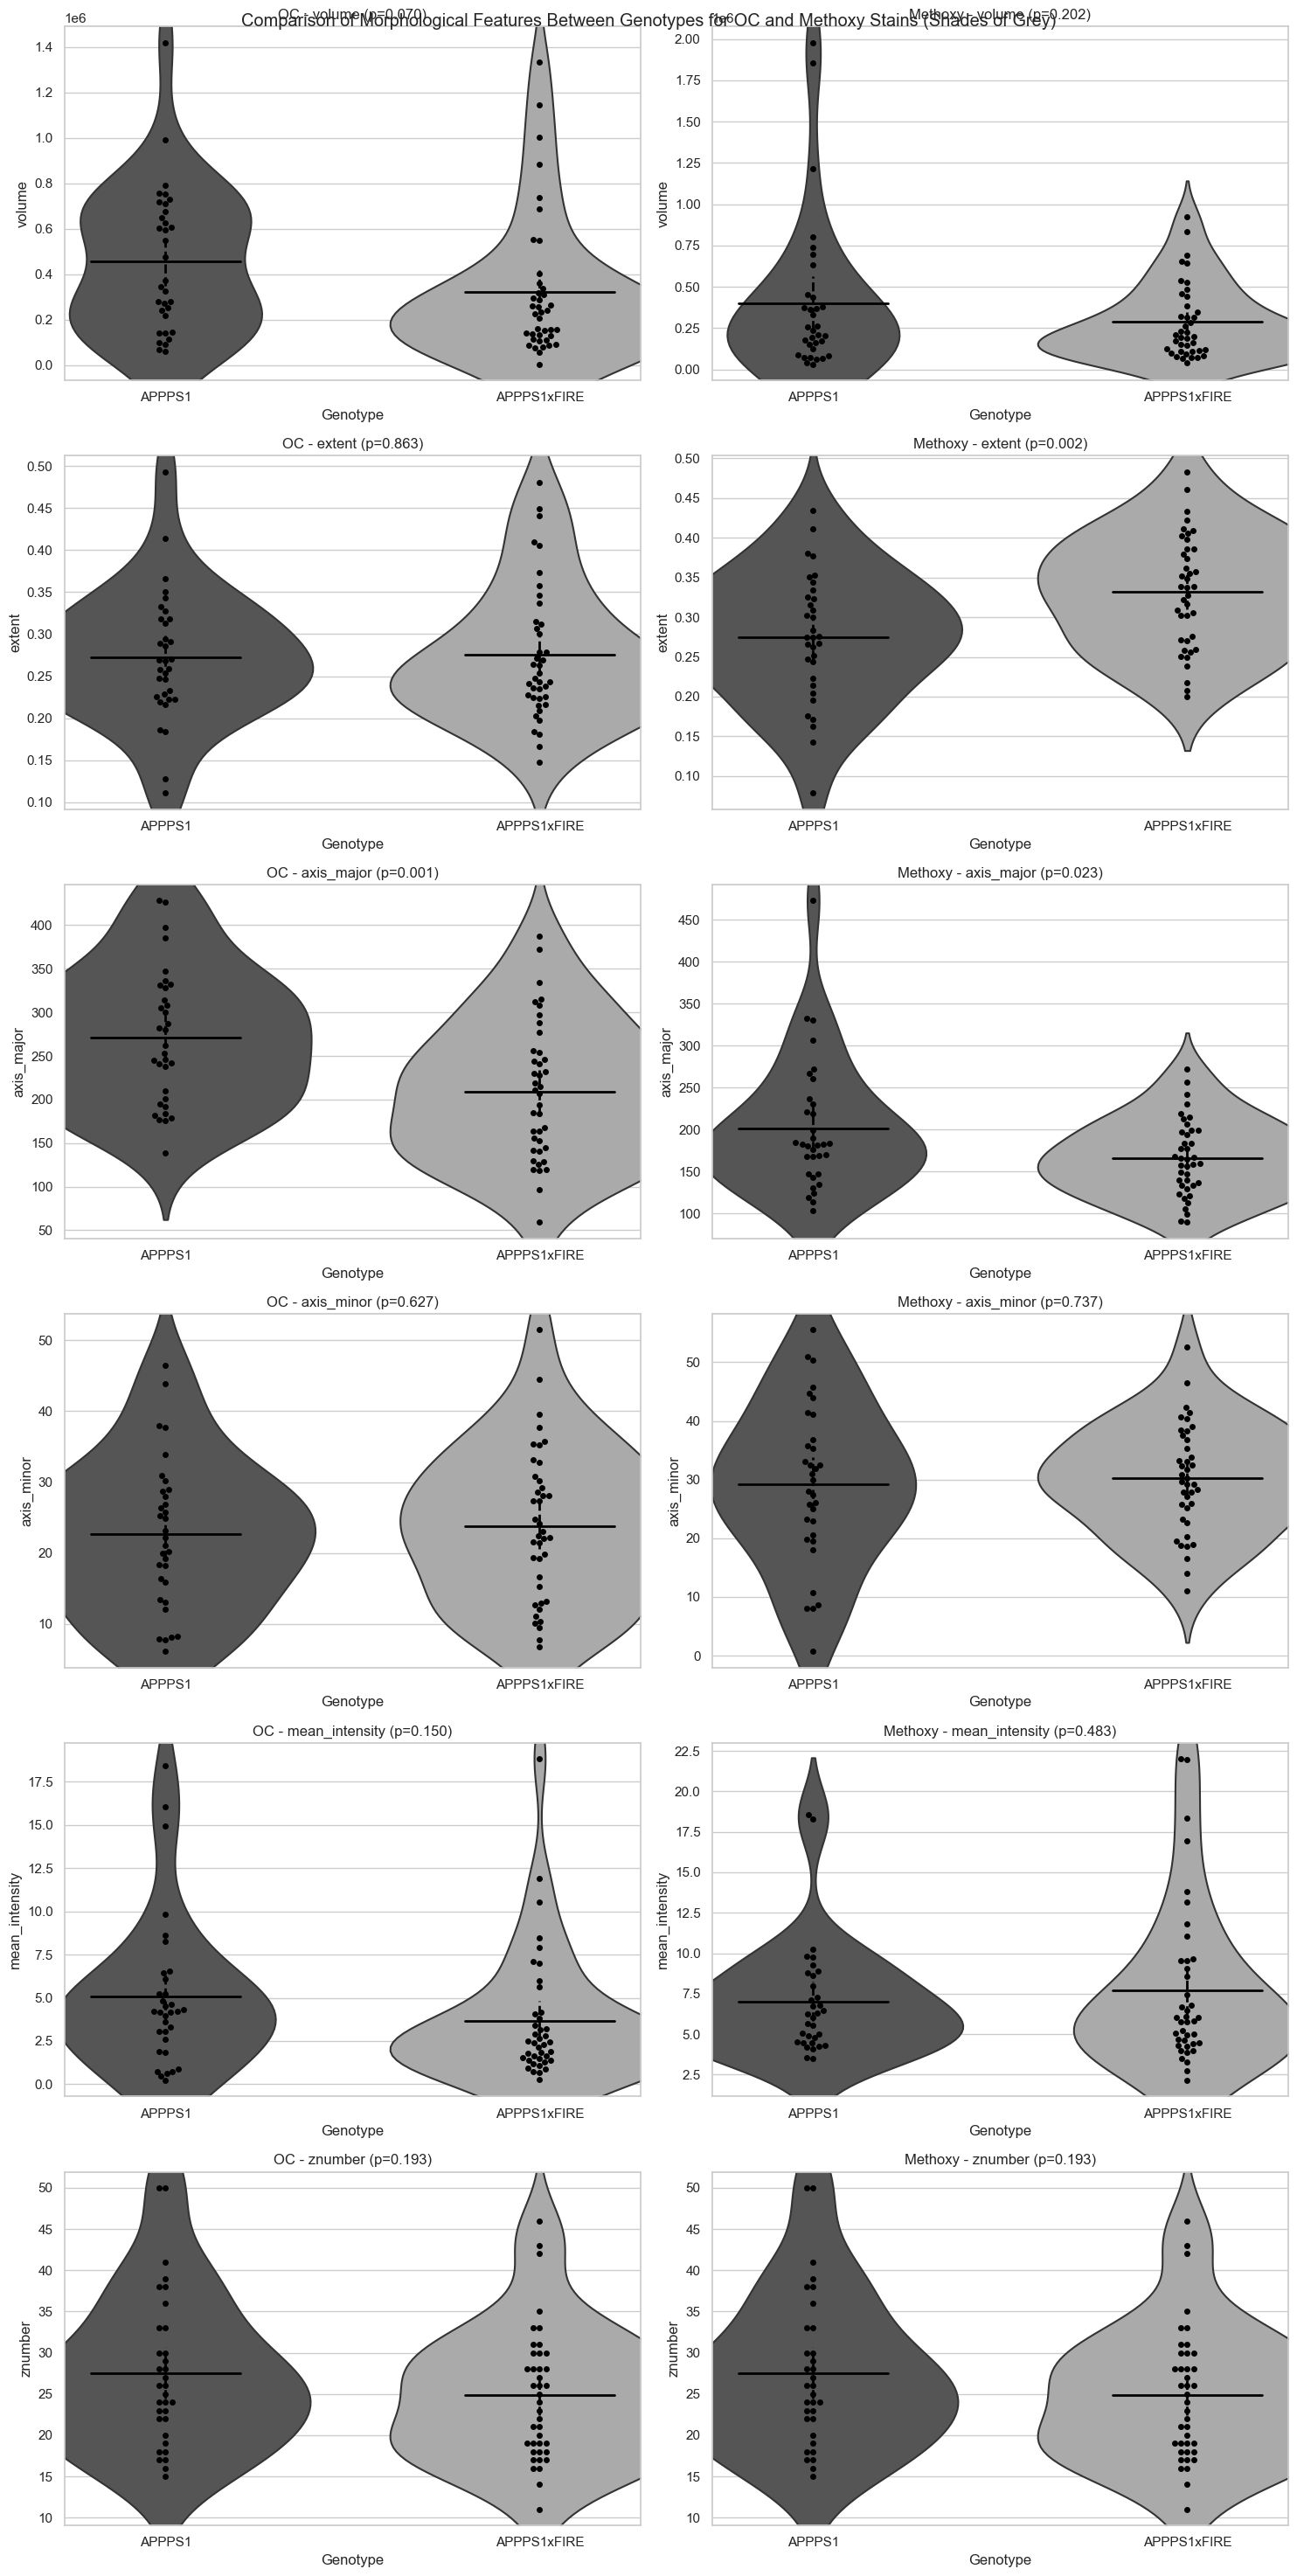

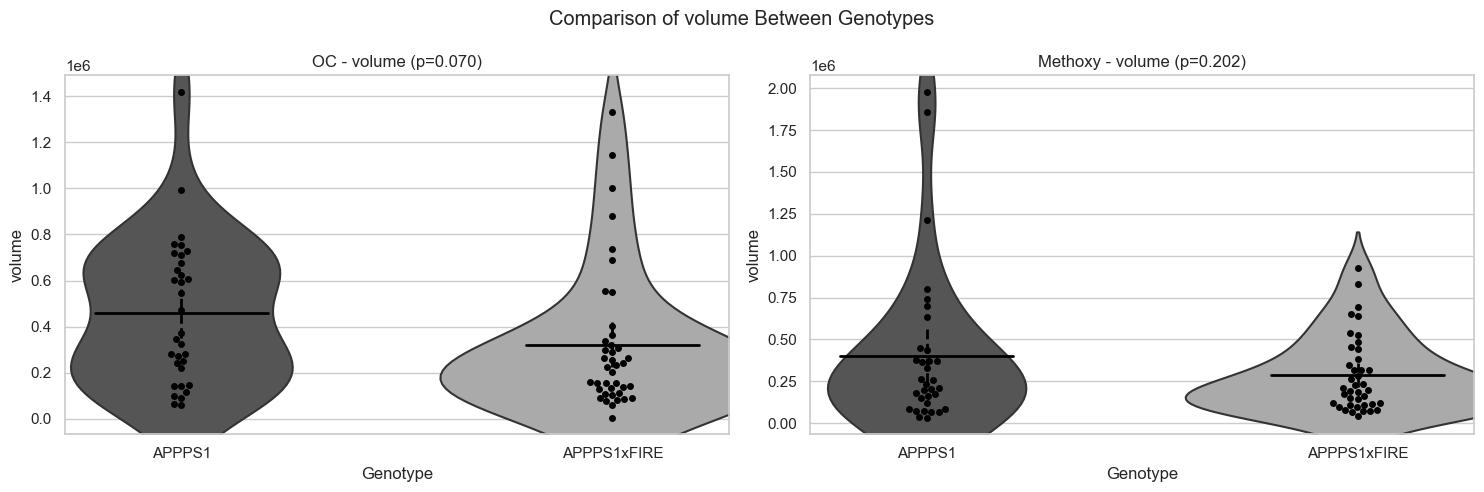

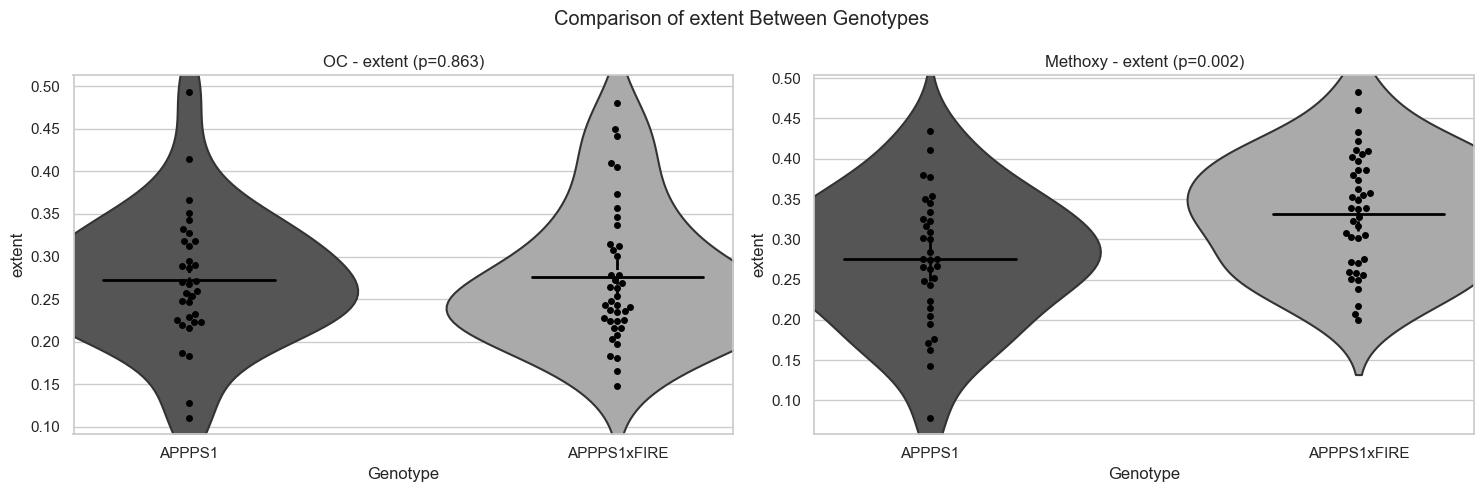

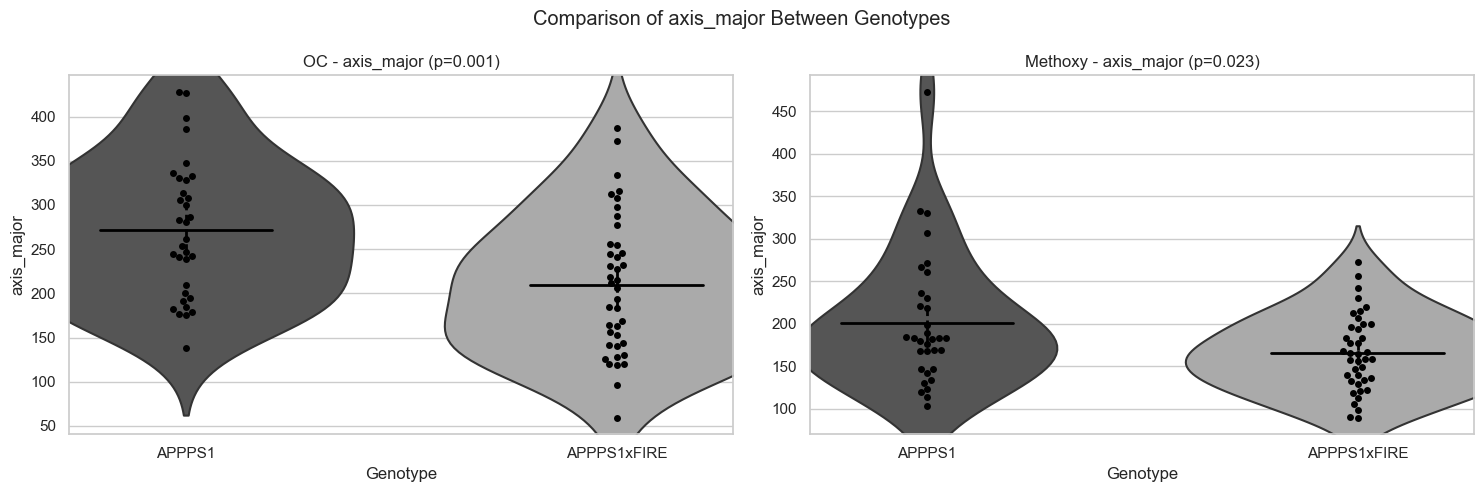

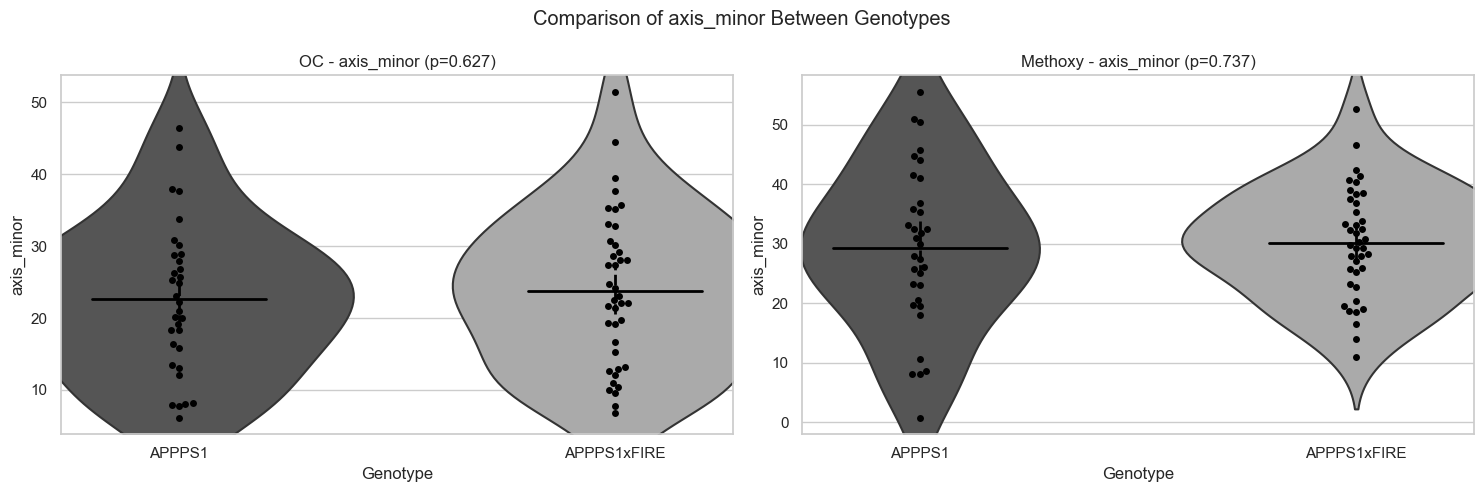

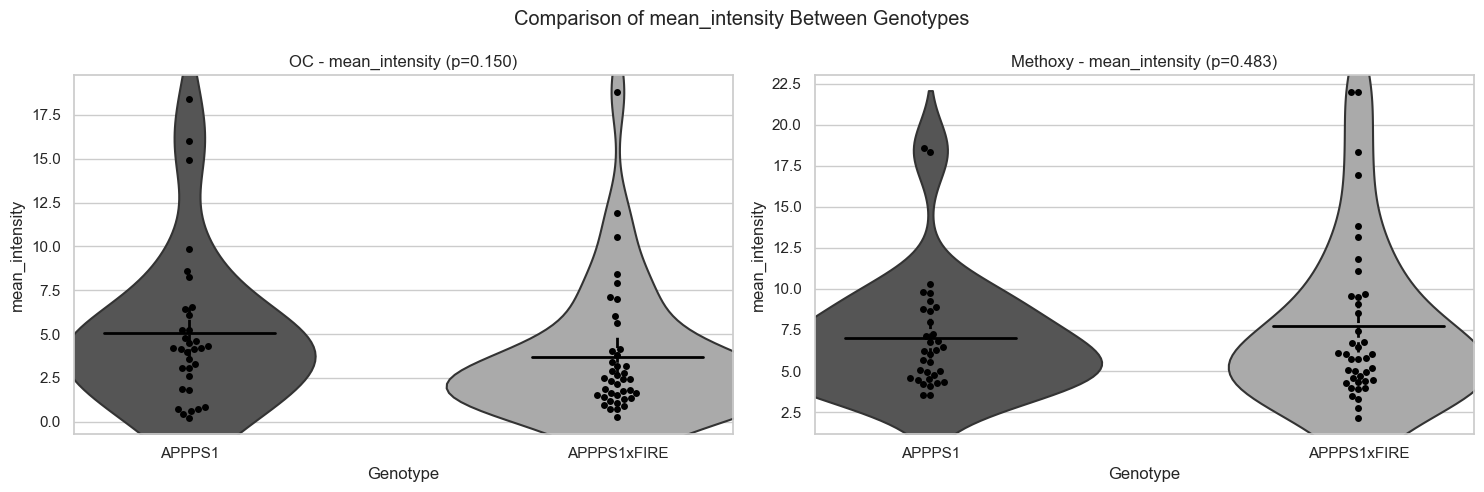

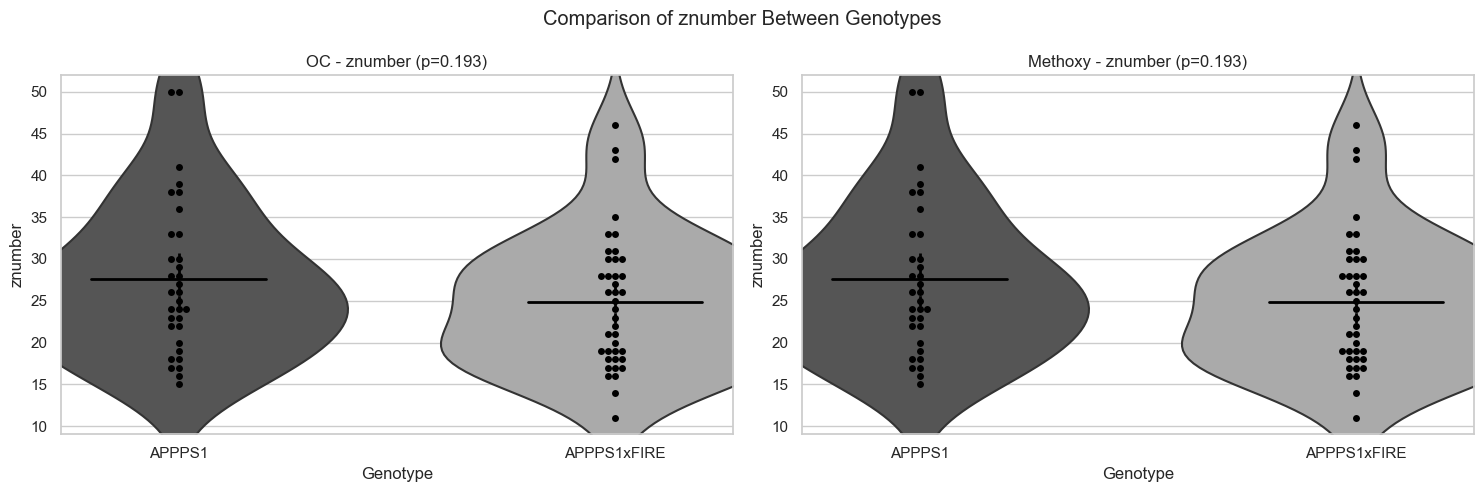

({'volume': {'t_statistic': 1.8420468507560244,
   'p_value': 0.06981630620883156},
  'extent': {'t_statistic': -0.1731183911532836, 'p_value': 0.863059997824893},
  'axis_major': {'t_statistic': 3.4011346615044236,
   'p_value': 0.001120979380918436},
  'axis_minor': {'t_statistic': -0.4879913311883014,
   'p_value': 0.6271056357054872},
  'mean_intensity': {'t_statistic': 1.4573092538596313,
   'p_value': 0.15001206887452667},
  'znumber': {'t_statistic': 1.314621984448995,
   'p_value': 0.19330480727071145}},
 {'volume': {'t_statistic': 1.2963181385031801, 'p_value': 0.2016331798348817},
  'extent': {'t_statistic': -3.1856973910229427,
   'p_value': 0.0022233970978848576},
  'axis_major': {'t_statistic': 2.3461998857020525,
   'p_value': 0.023031754970929744},
  'axis_minor': {'t_statistic': -0.338065113016487,
   'p_value': 0.7366137856505692},
  'mean_intensity': {'t_statistic': -0.7050084971831212,
   'p_value': 0.48315728242133504},
  'znumber': {'t_statistic': 1.314621984448995

In [74]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
metadata = pd.read_csv('/Users/katherineridley/APPFIRE_image/plaque-stack/metadata_updated.csv', index_col=0)
oc_morphology = pd.read_csv('/Users/katherineridley/APPFIRE_image/plaque-stack/oc_morphology_3d_norm255_filled.csv')
methoxy_morphology = pd.read_csv('/Users/katherineridley/APPFIRE_image/plaque-stack/methoxy_morphology_3d_norm255_filled.csv')

def select_largest_volume(data):
    return data.sort_values(by='volume', ascending=False).groupby('image').first()

# Applying the function to both datasets
oc_data_largest = select_largest_volume(oc_morphology)
methoxy_data_largest = select_largest_volume(methoxy_morphology)

# Merge the metadata with morphology data and remove unwanted column
oc_data_largest_merged = oc_data_largest.merge(metadata, left_on='image', right_index=True).drop(columns=['Methoxy_mean_intensity_norm', 'Methoxy_mean_intensity'])
methoxy_data_largest_merged = methoxy_data_largest.merge(metadata, left_on='image', right_index=True).drop(columns=['OC_mean_intensity_norm', 'OC_mean_intensity'])

# Rename the intensity column
oc_data_largest_merged.rename(columns={'OC_mean_intensity_norm': 'mean_intensity_norm', 'OC_mean_intensity': 'mean_intensity'}, inplace=True)
methoxy_data_largest_merged.rename(columns={'Methoxy_mean_intensity_norm': 'mean_intensity_norm', 'Methoxy_mean_intensity': 'mean_intensity'}, inplace=True)

# Define the variables to test and genotypes
variables = ['volume', 'extent', 'axis_major', 'axis_minor', 'mean_intensity', 'znumber']
genotype1 = 'APPPS1'
genotype2 = 'APPPS1xFIRE'

# Function to perform t-tests
def perform_t_tests(data, genotype1, genotype2, variables):
    results = {}
    for variable in variables:
        genotype1_values = data[data['Genotype'] == genotype1][variable]
        genotype2_values = data[data['Genotype'] == genotype2][variable]
        t_stat, p_value = stats.ttest_ind(genotype1_values, genotype2_values, equal_var=False)
        results[variable] = {'t_statistic': t_stat, 'p_value': p_value}
    return results


oc_data_largest_merged.to_csv('oc_data_merged.csv')
methoxy_data_largest_merged.to_csv('methoxy_data_merged.csv')

# Performing t-tests
oc_results_largest = perform_t_tests(oc_data_largest_merged, genotype1, genotype2, variables)
methoxy_results_largest = perform_t_tests(methoxy_data_largest_merged, genotype1, genotype2, variables)

# Plotting the results
# Adjusting the code to use shades of grey for the violin plots, with mean and CI lines and smaller black swarm dots

# Setting up the plot style for shades of grey
sns.set(style="whitegrid", palette="gray")

# Plotting parameters
swarm_color = 'black'  # Color for the swarm plot points
swarm_edgecolor = 'black'  # Edge color for the swarm plot points
swarm_size = 5  # Smaller size for the swarm plot points

# Creating the figure for the plots
fig, axes = plt.subplots(6, 2, figsize=(15, 30))
fig.suptitle('Comparison of Morphological Features Between Genotypes for OC and Methoxy Stains (Shades of Grey)')

# Function to add mean and CI lines
def add_mean_and_ci(ax, data, x, y, color):
    mean = data[y].mean()
    ci = 1.96 * data[y].sem()  # 95% CI
    ax.plot([x-0.2, x+0.2], [mean, mean], color=color, linestyle='-', linewidth=2)
    ax.plot([x, x], [mean - ci, mean + ci], color=color, linestyle='--', linewidth=2)

# Plotting for each variable and stain
for i, variable in enumerate(variables):
    # OC data
    ax = axes[i, 0]
    sns.violinplot(ax=ax, x='Genotype', y=variable, data=oc_data_largest_merged, inner=None, palette="gray")
    sns.swarmplot(ax=ax, x='Genotype', y=variable, data=oc_data_largest_merged, color=swarm_color, edgecolor=swarm_edgecolor, size=swarm_size)
    add_mean_and_ci(ax, oc_data_largest_merged[oc_data_largest_merged['Genotype'] == genotype1], 0, variable, 'black')
    add_mean_and_ci(ax, oc_data_largest_merged[oc_data_largest_merged['Genotype'] == genotype2], 1, variable, 'black')
    ax.set_title(f'OC - {variable} (p={oc_results_largest[variable]["p_value"]:.3f})')

    # Methoxy data
    ax = axes[i, 1]
    sns.violinplot(ax=ax, x='Genotype', y=variable, data=methoxy_data_largest_merged, inner=None, palette="gray")
    sns.swarmplot(ax=ax, x='Genotype', y=variable, data=methoxy_data_largest_merged, color=swarm_color, edgecolor=swarm_edgecolor, size=swarm_size)
    add_mean_and_ci(ax, methoxy_data_largest_merged[methoxy_data_largest_merged['Genotype'] == genotype1], 0, variable, 'black')
    add_mean_and_ci(ax, methoxy_data_largest_merged[methoxy_data_largest_merged['Genotype'] == genotype2], 1, variable, 'black')
    ax.set_title(f'Methoxy - {variable} (p={methoxy_results_largest[variable]["p_value"]:.3f})')

plt.tight_layout()
plt.show()

# To create individual plots for each variable, we'll loop through the variables and generate separate plots for each.

# Setting up the plot style for shades of grey
sns.set(style="whitegrid", palette="gray")

# Plot parameters
swarm_color = 'black'  # Color for the swarm plot points
swarm_edgecolor = 'black'  # Edge color for the swarm plot points
swarm_size = 5  # Size for the swarm plot points

# Function to add mean and CI lines
def add_mean_and_ci(ax, data, x, y, color):
    mean = data[y].mean()
    ci = 1.96 * data[y].sem()  # 95% CI
    ax.plot([x-0.2, x+0.2], [mean, mean], color=color, linestyle='-', linewidth=2)
    ax.plot([x, x], [mean - ci, mean + ci], color=color, linestyle='--', linewidth=2)

# Creating individual plots for each variable
for variable in variables:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Comparison of {variable} Between Genotypes')

    # OC data plot
    ax = axes[0]
    sns.violinplot(ax=ax, x='Genotype', y=variable, data=oc_data_largest_merged, inner=None, palette="gray")
    sns.swarmplot(ax=ax, x='Genotype', y=variable, data=oc_data_largest_merged, color=swarm_color, edgecolor=swarm_edgecolor, size=swarm_size)
    add_mean_and_ci(ax, oc_data_largest_merged[oc_data_largest_merged['Genotype'] == genotype1], 0, variable, 'black')
    add_mean_and_ci(ax, oc_data_largest_merged[oc_data_largest_merged['Genotype'] == genotype2], 1, variable, 'black')
    ax.set_title(f'OC - {variable} (p={oc_results_largest[variable]["p_value"]:.3f})')

    # Methoxy data plot
    ax = axes[1]
    sns.violinplot(ax=ax, x='Genotype', y=variable, data=methoxy_data_largest_merged, inner=None, palette="gray")
    sns.swarmplot(ax=ax, x='Genotype', y=variable, data=methoxy_data_largest_merged, color=swarm_color, edgecolor=swarm_edgecolor, size=swarm_size)
    add_mean_and_ci(ax, methoxy_data_largest_merged[methoxy_data_largest_merged['Genotype'] == genotype1], 0, variable, 'black')
    add_mean_and_ci(ax, methoxy_data_largest_merged[methoxy_data_largest_merged['Genotype'] == genotype2], 1, variable, 'black')
    ax.set_title(f'Methoxy - {variable} (p={methoxy_results_largest[variable]["p_value"]:.3f})')

    plt.tight_layout()
    plt.show()




# Returning the t-test results for the largest volume labels
oc_results_largest, methoxy_results_largest


In [43]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load your data
oc_data_largest_merged = pd.read_csv('oc_data_merged.csv')
methoxy_data_largest_merged = pd.read_csv('methoxy_data_merged.csv')

# Variables and genotypes
variables = ['volume', 'extent', 'axis_major', 'axis_minor', 'mean_intensity', 'znumber']
genotype1 = 'APPPS1'
genotype2 = 'APPPS1xFIRE'

# Function to fit multiple mixed linear models
def fit_mixed_models(data, variables, group_var='ID'):
    models = {}
    for variable in variables:
        # Defining the model
        model = smf.mixedlm(f"{variable} ~ Genotype", data, groups=data[group_var], re_formula="~Genotype")
        # Fitting the model
        result = model.fit()
        # Storing the result
        models[variable] = result
    return models

# Performing mixed model analysis
oc_mixed_models = fit_mixed_models(oc_data_largest_merged, variables)
methoxy_mixed_models = fit_mixed_models(methoxy_data_largest_merged, variables)

# Example to view results for 'volume' in oc_data
print(oc_mixed_models['volume'].summary())


/Users/katherineridley/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/katherineridley/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/katherineridley/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/katherineridley/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/katherineridley/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood o

LinAlgError: Singular matrix

In [78]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load your data
oc_data_largest_merged = pd.read_csv('oc_data_with_ratio_norm255.csv')
methoxy_data_largest_merged = pd.read_csv('methoxy_data_with_ratio_norm255.csv')



# Variables
variables = ['volume', 'extent', 'axis_major', 'axis_minor', 'mean_intensity', 'znumber', 'oc_methoxy_ratio']

# Function to fit multiple mixed linear models with a simpler structure
def fit_mixed_models(data, variables, group_var='ID'):
    models = {}
    for variable in variables:
        # Defining the model with only random intercepts
        model = smf.mixedlm(f"{variable} ~ Genotype", data, groups=data[group_var])
        # Fitting the model
        try:
            result = model.fit()
            models[variable] = result
        except np.linalg.LinAlgError:
            print(f"Failed to fit model for {variable} due to singular matrix")
    return models

# Performing mixed model analysis
oc_mixed_models = fit_mixed_models(oc_data_largest_merged, variables)
methoxy_mixed_models = fit_mixed_models(methoxy_data_largest_merged, variables)


#print(oc_mixed_models['volume'].summary())
print(methoxy_mixed_models['volume'].summary())
print(methoxy_mixed_models['extent'].summary())
print(methoxy_mixed_models['axis_major'].summary())
print(methoxy_mixed_models['oc_methoxy_ratio'].summary())


print(oc_mixed_models['volume'].summary())
print(oc_mixed_models['extent'].summary())
print(oc_mixed_models['axis_major'].summary())
print(oc_mixed_models['oc_methoxy_ratio'].summary())


/Users/katherineridley/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/katherineridley/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/katherineridley/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/katherineridley/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/katherineridley/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood o

                        Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        volume           
No. Observations:          73             Method:                    REML             
No. Groups:                12             Scale:                     117206082569.9953
Min. group size:           2              Log-Likelihood:            -1011.4879       
Max. group size:           10             Converged:                 Yes              
Mean group size:           6.1                                                        
--------------------------------------------------------------------------------------
                             Coef.       Std.Err.    z    P>|z|    [0.025     0.975]  
--------------------------------------------------------------------------------------
Intercept                    411886.436  79628.098  5.173 0.000  255818.232 567954.640
Genotype[T.APPPS1xFIRE]     -130110.723 105299.338 -1.236 0.217 -336

/Users/katherineridley/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/katherineridley/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2207: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/katherineridley/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2219: ConvergenceWarning: Gradient optimization failed, |grad| = 1.659269
  warnings.warn(msg, ConvergenceWarning)


In [75]:
import pandas as pd

# Load the datasets

oc_data = pd.read_csv('oc_data_merged.csv')
methoxy_data = pd.read_csv('methoxy_data_merged.csv')

# Merging the datasets on the 'image' column to calculate the volume ratio
merged_data = pd.merge(oc_data[['image', 'volume']], methoxy_data[['image', 'volume']], on='image', suffixes=('_oc', '_methoxy'))
merged_data['methoxy_oc_ratio'] = merged_data['volume_methoxy'] / merged_data['volume_oc']
merged_data['oc_methoxy_ratio'] =  merged_data['volume_oc'] / merged_data['volume_methoxy']
 
# Append the volume ratio to the original datasets
oc_data = oc_data.merge(merged_data[['image', 'methoxy_oc_ratio', 'oc_methoxy_ratio']], on='image')
methoxy_data = methoxy_data.merge(merged_data[['image', 'methoxy_oc_ratio', 'oc_methoxy_ratio']], on='image')

# Save the updated datasets to new CSV files
oc_data.to_csv('oc_data_with_ratio_norm255.csv')
methoxy_data.to_csv('methoxy_data_with_ratio_norm255.csv')


0.016


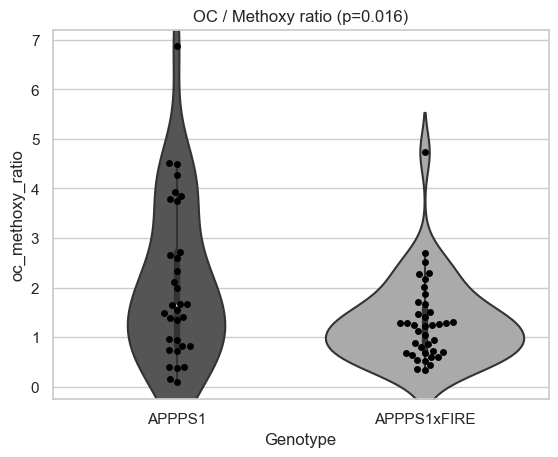

'for i, variable in enumerate(variables):\n    # OC data\n    ax = axes[i, 0]\n    sns.violinplot(ax=ax, x=\'Genotype\', y=variable, data=oc_data_largest_merged, inner=None, palette="gray")\n    sns.swarmplot(ax=ax, x=\'Genotype\', y=variable, data=oc_data_largest_merged, color=swarm_color, edgecolor=swarm_edgecolor, size=swarm_size)\n    add_mean_and_ci(ax, oc_data_largest_merged[oc_data_largest_merged[\'Genotype\'] == genotype1], 0, variable, \'black\')\n    add_mean_and_ci(ax, oc_data_largest_merged[oc_data_largest_merged[\'Genotype\'] == genotype2], 1, variable, \'black\')\n    ax.set_title(f\'OC - {variable} (p={oc_results_largest[variable]["p_value"]:.3f})\')\n\n    # Methoxy data\n    ax = axes[i, 1]\n    sns.violinplot(ax=ax, x=\'Genotype\', y=variable, data=methoxy_data_largest_merged, inner=None, palette="gray")\n    sns.swarmplot(ax=ax, x=\'Genotype\', y=variable, data=methoxy_data_largest_merged, color=swarm_color, edgecolor=swarm_edgecolor, size=swarm_size)\n    add_mean_a

2024-01-12 13:08:47.195 python[7979:9817769] GLDRendererMetal command buffer completion error: Error Domain=MTLCommandBufferErrorDomain Code=8 "Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)" UserInfo={NSLocalizedDescription=Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)}
2024-01-12 13:08:47.261 python[7979:9817630] GLDRendererMetal command buffer completion error: Error Domain=MTLCommandBufferErrorDomain Code=8 "Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)" UserInfo={NSLocalizedDescription=Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)}
Context leak detected, msgtracer returned -1
Traceback (most recent call last):
  File "/Users/katherineridley/anaconda3/lib/python3.11/site-packages/napari_animation/_qt/animation_widget.py", line 161, in _save_callback
    if animation_kwargs.get("filename", None) is not None:
       ^^^^^^^^^^^^^^^^^^^^
AttributeError: 'str' object has n

Rendering frames...


100%|██████████| 288/288 [00:19<00:00, 14.87it/s]
2024-01-12 13:11:27.426 python[7979:10168809] GLDRendererMetal command buffer completion error: Error Domain=MTLCommandBufferErrorDomain Code=8 "Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)" UserInfo={NSLocalizedDescription=Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)}
Context leak detected, msgtracer returned -1
2024-01-12 13:11:27.496 python[7979:10168447] GLDRendererMetal command buffer completion error: Error Domain=MTLCommandBufferErrorDomain Code=8 "Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)" UserInfo={NSLocalizedDescription=Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)}
2024-01-12 13:13:21.406 python[7979:10349748] GLDRendererMetal command buffer completion error: Error Domain=MTLCommandBufferErrorDomain Code=8 "Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)" UserInfo={NSLocalizedDes

Rendering frames...


100%|██████████| 306/306 [00:20<00:00, 15.21it/s]


Rendering frames...


100%|██████████| 306/306 [00:19<00:00, 16.10it/s]


Rendering frames...


100%|██████████| 306/306 [00:19<00:00, 15.46it/s]


In [ ]:
variables = ['volume', 'extent', 'axis_major', 'axis_minor', 'mean_intensity', 'znumber','methoxy_oc_ratio', 'oc_methoxy_ratio']
genotype1 = 'APPPS1'
genotype2 = 'APPPS1xFIRE'



# Function to perform t-tests
def perform_t_tests(data, genotype1, genotype2, variables):
    results = {}
    for variable in variables:
        genotype1_values = data[data['Genotype'] == genotype1][variable]
        genotype2_values = data[data['Genotype'] == genotype2][variable]
        t_stat, p_value = stats.ttest_ind(genotype1_values, genotype2_values, equal_var=False)
        results[variable] = {'t_statistic': t_stat, 'p_value': p_value}
    return results


oc_data_largest_merged = pd.read_csv('oc_data_with_ratio.csv')
methoxy_data_largest_merged = pd.read_csv('methoxy_data_with_ratio.csv')

oc_data_filtered = oc_data_largest_merged[oc_data_largest_merged['methoxy_oc_ratio'] <= 30]


oc_results_largest = perform_t_tests(oc_data_filtered, genotype1, genotype2, variables)
methoxy_results_largest = perform_t_tests(methoxy_data_largest_merged, genotype1, genotype2, variables)

oc_results = pd.DataFrame.from_dict(oc_results_largest)
methoxy_results = pd.DataFrame.from_dict(methoxy_results_largest)
oc_results.to_csv('oc_ttest_results.csv')
methoxy_results.to_csv('methoxy_ttest_results.csv')
# Plotting the results
# Adjusting the code to use shades of grey for the violin plots, with mean and CI lines and smaller black swarm dots

# Setting up the plot style for shades of grey
sns.set(style="whitegrid", palette="gray")

# Plotting parameters
swarm_color = 'black'  # Color for the swarm plot points
swarm_edgecolor = 'black'  # Edge color for the swarm plot points
swarm_size = 5  # Smaller size for the swarm plot points

# Creating the figure for the plots
#fig, axes = plt.subplots(6, 2, figsize=(15, 30))
ax = plt.figure()

# Function to add mean and CI lines
def add_mean_and_ci(ax, data, x, y, color):
    mean = data[y].mean()
    ci = 1.96 * data[y].sem()  # 95% CI
    ax.plot([x-0.2, x+0.2], [mean, mean], color=color, linestyle='-', linewidth=2)
    ax.plot([x, x], [mean - ci, mean + ci], color=color, linestyle='--', linewidth=2)

variable = 'oc_methoxy_ratio'
sns.violinplot(x='Genotype', y=variable, data=oc_data_filtered, palette="gray")
sns.swarmplot(x='Genotype', y=variable, data=oc_data_filtered, color=swarm_color, edgecolor=swarm_edgecolor, size=swarm_size)
#add_mean_and_ci(ax, oc_data_largest_merged[oc_data_largest_merged['Genotype'] == genotype1], 0, variable, 'black')
#add_mean_and_ci(ax, oc_data_largest_merged[oc_data_largest_merged['Genotype'] == genotype2], 1, variable, 'black')
plt.title(f'OC / Methoxy ratio (p={oc_results_largest[variable]["p_value"]:.3f})')
print(f'{oc_results_largest[variable]["p_value"]:.3f}')
plt.show()

# Plotting for each variable and stain
'''for i, variable in enumerate(variables):
    # OC data
    ax = axes[i, 0]
    sns.violinplot(ax=ax, x='Genotype', y=variable, data=oc_data_largest_merged, inner=None, palette="gray")
    sns.swarmplot(ax=ax, x='Genotype', y=variable, data=oc_data_largest_merged, color=swarm_color, edgecolor=swarm_edgecolor, size=swarm_size)
    add_mean_and_ci(ax, oc_data_largest_merged[oc_data_largest_merged['Genotype'] == genotype1], 0, variable, 'black')
    add_mean_and_ci(ax, oc_data_largest_merged[oc_data_largest_merged['Genotype'] == genotype2], 1, variable, 'black')
    ax.set_title(f'OC - {variable} (p={oc_results_largest[variable]["p_value"]:.3f})')

    # Methoxy data
    ax = axes[i, 1]
    sns.violinplot(ax=ax, x='Genotype', y=variable, data=methoxy_data_largest_merged, inner=None, palette="gray")
    sns.swarmplot(ax=ax, x='Genotype', y=variable, data=methoxy_data_largest_merged, color=swarm_color, edgecolor=swarm_edgecolor, size=swarm_size)
    add_mean_and_ci(ax, methoxy_data_largest_merged[methoxy_data_largest_merged['Genotype'] == genotype1], 0, variable, 'black')
    add_mean_and_ci(ax, methoxy_data_largest_merged[methoxy_data_largest_merged['Genotype'] == genotype2], 1, variable, 'black')
    ax.set_title(f'Methoxy - {variable} (p={methoxy_results_largest[variable]["p_value"]:.3f})')

plt.tight_layout()
plt.show()

# To create individual plots for each variable, we'll loop through the variables and generate separate plots for each.

# Setting up the plot style for shades of grey
sns.set(style="whitegrid", palette="gray")

# Plot parameters
swarm_color = 'black'  # Color for the swarm plot points
swarm_edgecolor = 'black'  # Edge color for the swarm plot points
swarm_size = 5  # Size for the swarm plot points

# Function to add mean and CI lines
def add_mean_and_ci(ax, data, x, y, color):
    mean = data[y].mean()
    ci = 1.96 * data[y].sem()  # 95% CI
    ax.plot([x-0.2, x+0.2], [mean, mean], color=color, linestyle='-', linewidth=2)
    ax.plot([x, x], [mean - ci, mean + ci], color=color, linestyle='--', linewidth=2)

# Creating individual plots for each variable
for variable in variables:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Comparison of {variable} Between Genotypes')

    # OC data plot
    ax = axes[0]
    sns.violinplot(ax=ax, x='Genotype', y=variable, data=oc_data_largest_merged, inner=None, palette="gray")
    sns.swarmplot(ax=ax, x='Genotype', y=variable, data=oc_data_largest_merged, color=swarm_color, edgecolor=swarm_edgecolor, size=swarm_size)
    add_mean_and_ci(ax, oc_data_largest_merged[oc_data_largest_merged['Genotype'] == genotype1], 0, variable, 'black')
    add_mean_and_ci(ax, oc_data_largest_merged[oc_data_largest_merged['Genotype'] == genotype2], 1, variable, 'black')
    ax.set_title(f'OC - {variable} (p={oc_results_largest[variable]["p_value"]:.3f})')

    # Methoxy data plot
    ax = axes[1]
    sns.violinplot(ax=ax, x='Genotype', y=variable, data=methoxy_data_largest_merged, inner=None, palette="gray")
    sns.swarmplot(ax=ax, x='Genotype', y=variable, data=methoxy_data_largest_merged, color=swarm_color, edgecolor=swarm_edgecolor, size=swarm_size)
    add_mean_and_ci(ax, methoxy_data_largest_merged[methoxy_data_largest_merged['Genotype'] == genotype1], 0, variable, 'black')
    add_mean_and_ci(ax, methoxy_data_largest_merged[methoxy_data_largest_merged['Genotype'] == genotype2], 1, variable, 'black')
    ax.set_title(f'Methoxy - {variable} (p={methoxy_results_largest[variable]["p_value"]:.3f})')

    plt.tight_layout()
    plt.show()




# Returning the t-test results for the largest volume labels
oc_results_largest, methoxy_results_largest'''

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np

parent_dir = "/Users/katherineridley/APPFIRE_image/TIFFs/ProcessedImages"
metadata_path = "/Users/katherineridley/APPFIRE_image/plaque-stack/metadata_updated.csv"
metadata = pd.read_csv(metadata_path, index_col=0)

# Initialize columns for mean intensities


# Function to calculate normalized mean intensity
def calculate_mean_intensity(image_path):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Calculate and return normalized mean intensity
    return np.mean(image)

# Loop through each subfolder in the parent directory
for folder in os.listdir(parent_dir):
    folder_path = os.path.join(parent_dir, folder)
    if os.path.isdir(folder_path):
        image_dir = os.path.join(folder_path, "mask_window_stacks")

        # Process images in the subfolder
        for image_file in os.listdir(image_dir):
            image_path = os.path.join(image_dir, image_file)
            if 'OC' in image_file:
                intensity = calculate_mean_intensity(image_path)
                # Update the metadata DataFrame
                if folder in metadata.index:
                    metadata.at[folder, 'OC_mean_intensity_thresholded'] = intensity
                    metadata.at[folder, 'OC_mean_intensity_thresholded'] = intensity*255
            elif 'Methoxy' in image_file:
                intensity = calculate_mean_intensity(image_path)
                # Update the metadata DataFrame
                if folder in metadata.index:
                    metadata.at[folder, 'Methoxy_mean_intensity_thresholded'] = intensity
                    metadata.at[folder, 'Methoxy_mean_intensity_thresholded'] = intensity*255

'''for folder in os.listdir(parent_dir):
    folder_path = os.path.join(parent_dir, folder)
    if os.path.isdir(folder_path):
        image_dir = os.path.join(folder_path, "background_corrected_stacks")

        # Process images in the subfolder
        for image_file in os.listdir(image_dir):
            image_path = os.path.join(image_dir, image_file)
            if 'OC' in image_file:
                intensity = calculate_mean_intensity(image_path)
                # Update the metadata DataFrame
                if folder in metadata.index:
                    metadata.at[folder, 'OC_mean_intensity_bgcorrected'] = intensity*255
                    
            elif 'Methoxy' in image_file:
                intensity = calculate_mean_intensity(image_path)
                # Update the metadata DataFrame
                if folder in metadata.index:
                    metadata.at[folder, 'Methoxy_mean_intensity_bgcorrected'] = intensity*255'''
                   

# Save the updated metadata
metadata.to_csv("/Users/katherineridley/APPFIRE_image/plaque-stack/metadata_updated.csv")


In [ ]:


channels = pd.DataFrame.from_dict(channel_masks, orient='index')
channels.to_csv('channel_masks_2.csv')



In [ ]:
from naparimovie import Movie
from napari_animation import Animation
import vispy

viewer = napari.Viewer()

#red = vispy.color.Colormap([[0., 0.0, 0.0], [
green = vispy.color.Colormap([[0.8, 1.0, 0.8], [0.0, 1.0, 0.0]])
blue = vispy.color.Colormap([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0]])

for image, channel_info in channel_masks.items():
    if image == 'B_3_M04_OC_L23_P+_061123_1.tif':
        print(image)
        # 'channel_info' is the nested dictionary for each image
        for channel, masks in channel_info.items():
            print(channel)
            if channel == 0:
                #label = Colormap(['#EE82EE'])
                # This is the list of all masks, handle accordingly
                # ... process 'mask_list' which contains all masks for this image ...
                
                stacked_masks = np.stack(masks, axis=0)
                # Stack boundaries similarly
                stacked_boundaries = np.stack([find_boundaries(mask) for mask in masks], axis=0)

                # Add original mask
                #viewer.add_image(stacked_masks, name=f'Channel {channel} Masks', contrast_limits=(0, 1))

                # Add boundaries as another layer
                labels=viewer.add_labels(stacked_boundaries, name=f'Channel {channel} Boundaries')
                #labels.colormap = 'blue', blue

            elif channel== 1:

                stacked_masks = np.stack(masks, axis=0)
                # Stack boundaries similarly
                stacked_boundaries = np.stack([find_boundaries(mask) for mask in masks], axis=0)

                # Add original mask
                #viewer.add_image(stacked_masks, name=f'Channel {channel} Masks', contrast_limits=(0, 1))

                # Add boundaries as another layer
                labels = viewer.add_labels(stacked_boundaries, name=f'Channel {channel} Boundaries')
                #labels=viewer.add_labels(stacked_boundaries, name=f'Channel {channel} Boundaries')
                labels.blending='additive'
                #labels.colormap = 'red', green

                frames = []

            #movie = Movie(viewer)
            #movie.inter_steps = 30
            #movie.make_movie(name = 'movie.mp4', resolution = 300, fps = 20)
            #movie.make_gif('gifmovie.gif')
            
            napari.run()

  


In [ ]:
pip install git+https://github.com/guiwitz/naparimovie.git@master#egg=naparimovie

In [ ]:
for channel, masks in channel_masks.items():
    stacked_masks = np.stack(masks, axis=0)
    # Stack boundaries similarly
    stacked_boundaries = np.stack([find_boundaries(mask) for mask in masks], axis=0)

    # Add original mask
    viewer.add_image(stacked_masks, name=f'Channel {channel} Masks', contrast_limits=(0, 1))

    # Add boundaries as another layer
    viewer.add_labels(stacked_boundaries, name=f'Channel {channel} Boundaries')

    napari.run()

In [ ]:
viewer = napari.Viewer()

for channel, masks in channel_masks.items():
    print(channel)
    stacked_masks = np.stack(masks, axis=0)
    # Stack boundaries similarly
    stacked_boundaries = np.stack([find_boundaries(mask) for mask in masks], axis=0)

    # Add original mask
    viewer.add_image(stacked_masks, name=f'Channel {channel} Masks', contrast_limits=(0, 1))

    # Add boundaries as another layer
    viewer.add_labels(stacked_boundaries, name=f'Channel {channel} Boundaries')

    napari.run()

for channel, masks in channel_masks.items():
    for i, mask in enumerate(masks):
        # Find boundaries
        boundaries = find_boundaries(mask)

        # Visualize in Matplotlib
        plt.figure(figsize=(10, 5))
        plt.imshow(mask, cmap='gray')  # Show the original mask
        plt.imshow(boundaries, cmap='magma', alpha=0.5)  # Overlay boundaries
        plt.title(f'Channel {channel} - Mask {i} with Boundaries')
        plt.show()

video_path = os.path.join(outputfolder, '3dvideo.mp4')

# Record a video
with napari.gui_qt():
    # Set the desired duration and frames per second for the video
    total_duration_sec = 5
    fps = 30

    total_frames = total_duration_sec * fps
    for frame in range(total_frames):
        # Here you can modify the viewer, e.g., rotate or zoom
        # Example: Rotate the view
        viewer.dims.ndisplay = 3
        viewer.dims.point = [frame, frame, frame]  # Change this as needed
        # Capture the frame
        nbscreenshot(viewer, canvas_only=False).save(f'{frame}.png')

    # Use imageio to compile the saved frames into a video
    import imageio
    with imageio.get_writer(video_path, fps=fps) as writer:
        for frame in range(total_frames):
            writer.append_data(imageio.imread(f'{frame}.png'))




In [ ]:

import numpy as np
import skimage.io as io
import skimage.io as io
from skimage.filters import threshold_otsu
from scipy.ndimage import label, binary_fill_holes
import matplotlib.pyplot as plt
import os
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
from matplotlib.colors import ListedColormap
from skimage import io, exposure, data
from skimage.filters import gaussian
from skimage.filters import threshold_local
from skimage.filters import try_all_threshold
from skimage.filters import threshold_yen, sobel, threshold_isodata, threshold_multiotsu
import napari
import pandas as pd
from skimage.segmentation import find_boundaries



input_dir = "/Users/katherineridley/APPFIRE_image/TIFFs/"
output_dir = "/Users/katherineridley/APPFIRE_image/TIFFs/thresholded/"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

plaques = [image for image in os.listdir(input_dir) if 'P+' in image]
viewer = napari.Viewer()

# Initialize a dictionary to store masks for each channel
fl_channels = [0, 1]
channel_masks = {channel: [] for channel in fl_channels}



#for image in plaques:

image = 'F_3_M04_OC_L1_P+_231123_1.tif'
# Construct the control image filename by replacing 'P+' with 'P-'
control_image = image.replace('P+', 'P-')

# Read the experimental image stack
image_stack = io.imread(os.path.join(input_dir, image))

# Read the corresponding negative control image stack
control_stack = io.imread(os.path.join(input_dir, control_image))

# Ensure the dimensions match between the image and control stacks
assert image_stack.shape == control_stack.shape, "Mismatch in image and control stack dimensions"




outputfolder = os.path.join(output_dir, image)
os.makedirs(outputfolder, exist_ok=True) 
# Define fluorescent channels


# Initialize a dictionary to store thresholds

for channel in fl_channels:
    if channel == 0:
        protein = 'Methoxy-0-4'

    else:
        protein = 'OC'

    binary_masks = []
    # Process each z-plane
    for z_plane in range(image_stack.shape[0]):
        # Calculate the central region
        height, width = image_stack[z_plane, channel].shape
        center_y, center_x = height // 2, width // 2
        delta_y, delta_x = height // 4, width // 4  # 50% of the height and width
        y_min, y_max = center_y - delta_y, center_y + delta_y
        x_min, x_max = center_x - delta_x, center_x + delta_x

        center_fraction = 0.4  # For example, use 40% of the height and width instead of 50%
        delta_y, delta_x = int(height * center_fraction / 2), int(width * center_fraction / 2)
        y_min, y_max = center_y - delta_y, center_y + delta_y
        x_min, x_max = center_x - delta_x, center_x + delta_x

        # Crop the smaller central region
        central_region = image_stack[z_plane, channel][y_min:y_max, x_min:x_max]

        central_control = control_stack[z_plane, channel][y_min:y_max, x_min:x_max]

        backgroundthreshold = threshold_otsu(central_control)
        originalthreshold = threshold_otsu(central_region)
        #print('whole image:', np.mean(image_stack), 'central z plane:', np.mean(central_region), 'whole control:', np.mean(control_stack), 'control z plane:', np.mean(central_control))

        background_corrected_image = (central_region.astype(np.float32) - (central_control.astype(np.float32)))
        
        # Set any negative values to zero
        background_corrected_image[background_corrected_image < 0] = 0

        hard_cutoff= 5
        image_cutoff = image_stack > hard_cutoff
        v_min, v_max = np.percentile(background_corrected_image, (0.05, 99.99))
        # Apply threshold to the central region
        image_minmax_scaled = exposure.rescale_intensity(background_corrected_image, in_range=(v_min, v_max), out_range=(0,50))
        
        #print('mean:', np.mean(image_minmax_scaled))
        #print('max:',np.max(image_minmax_scaled))
        #sigma=1
        #blurred_image = gaussian(image_minmax_scaled, sigma=sigma, mode='nearest')
        
        #better_contrast = exposure.rescale_intensity(image_minmax_scaled[z_plane, channel], in_range=(v_min, v_max))
        threshold_value = (threshold_otsu(image_minmax_scaled))

        #threshold_value = threshold_local(central_region, block_size=3, offset=-0.1)

        #apply thrshold from entire stack>>
        '''image_minmax_scaled = exposure.rescale_intensity(image_stack)
        sigma=0.1
        #blurred_image = gaussian(image_stack, sigma=sigma, mode='nearest')
        v_min, v_max = np.percentile(image_stack, (0.2, 99.8))

        

        better_contrast = exposure.rescale_intensity(image_minmax_scaled)
        threshold_value = threshold_otsu(image_stack[:, channel])
        intensity_cutoff = np.percentile(image_stack, 20) 
        if channel == 0:
            offset = 0.3
        else:
            offset = 1
        threshold_value = threshold_value * offset'''
        
        #binary_mask = central_region > threshold_value

        #>>new code<<
        #block_size = 35  # This is a parameter you may need to tune
        #local_thresh = threshold_local(central_region, block_size, offset=50)
        #binary_mask = central_region > local_thresh

        binary_mask = central_region > threshold_value

        #print(threshold_value)


        # Process the binary mask
        filled_mask = binary_fill_holes(binary_mask)
        cleaned_mask, _ = label(filled_mask)
        size = np.bincount(cleaned_mask.flatten())

        # Check if there are non-zero elements in 'size' after the first element
        if len(size) > 1:
            largest_component = np.argmax(size[1:]) + 1
            cleaned_mask = cleaned_mask == largest_component
        else:
            # If no connected components, use an empty mask
            cleaned_mask = np.zeros_like(cleaned_mask)

        # Create an empty mask for the whole image
        full_cleaned_mask = np.zeros_like(image_stack[z_plane, channel])
        # Place the processed central region back into the full mask
        full_cleaned_mask[y_min:y_max, x_min:x_max] = cleaned_mask

        #print(full_cleaned_mask)

        # Instead of binary_masks.append, use:
        channel_masks[channel].append(full_cleaned_mask)
        


        # After processing all images, add them to the viewer




        #brightness_increase = 1000  # Adjust this value as needed

        # Increase brightness
        #brightened_image = image_stack + brightness_increase

        '''image_minmax_scaled = exposure.rescale_intensity(background_corrected_image)
        better_contrast = exposure.rescale_intensity(image_minmax_scaled)
        v_min, v_max = np.percentile(image_stack, (0.2, 99.8))

        

        better_contrast = exposure.rescale_intensity(image_stack, in_range=(v_min, v_max))
        #fig, ax = try_all_threshold(z_plane, figsize=(10, 8), verbose=False)
        #plt.show()

        # Visualize the results
        plt.figure(figsize=(10, 5))
        plt.suptitle(f'Protein {protein}, Z-Plane: {z_plane}')

        # Display the original image for the current z-plane
        plt.subplot(1, 2, 1)
        plt.imshow(better_contrast[z_plane, channel], cmap='gray')
        plt.title('Original Image')

        # Display the segmented volume for the current z-plane
        plt.subplot(1, 2, 2)
        plt.imshow(full_cleaned_mask, cmap='gray')
        plt.title('Segmented Volume')

        plt.tight_layout()
        plt.savefig(os.path.join(outputfolder, f"{image}_{z_plane}_c{channel}_thresh_otsu.png"))
        plt.show()'''




for channel, masks in channel_masks.items():
    stacked_masks = np.stack(masks, axis=0)
    # Stack boundaries similarly
    stacked_boundaries = np.stack([find_boundaries(mask) for mask in masks], axis=0)

    # Add original mask
    viewer.add_image(stacked_masks, name=f'Channel {channel} Masks', contrast_limits=(0, 1))

    # Add boundaries as another layer
    viewer.add_labels(stacked_boundaries, name=f'Channel {channel} Boundaries')

napari.run()




In [ ]:
import tifffile as tiff
import cv2 as cv
import numpy as np

# Read the OME-TIFF file
img_stack = tiff.imread('/Users/katherineridley/APPFIRE_image/OMETIFFs/F_2_M04_OC_L23_P+_231123_1_c0.ome.tiff', is_ome=False)

# Check if the image stack has been loaded
assert img_stack is not None, "file could not be read, check with os.path.exists()"

# Process each slice in the Z-stack
for z in range(img_stack.shape[0]):  # Assuming Z is the first dimension
    img = img_stack[z, :, :]

    # Convert to grayscale if necessary
    if len(img.shape) > 2:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    else:
        gray = img

    # Apply your existing processing steps to each slice
    # For example, thresholding:
    ret, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
    # sure background area
    sure_bg = cv.dilate(opening,kernel,iterations=3)
    # Finding sure foreground area
    dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
    ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)

    unknown = cv.subtract(sure_bg,sure_fg)

    # Marker labelling
    ret, markers = cv.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    #markers = cv.watershed(img,markers)
    #img[markers == -1] = [255,0,0]
    # ... continue with your processing steps

    # Display the processed slice
    cv.imshow(f'Slice {z}', gray)
    cv.waitKey(0)

cv.destroyAllWindows()


### java dependencies need sorting before being able to deploy javabridge

## skeleton notebook

In [ ]:
import os
import javabridge
import bioformats
import numpy as np
from tifffile import imsave

def lif_to_tiff(input_path, output_dir, ome_tiff=False):
    # Start the Java Virtual Machine
    javabridge.start_vm(class_path=bioformats.JARS)

    # Read the .lif file with bioformats
    r = bioformats.ImageReader(input_path)
    
    # Determine number of series (individual images) in the .lif file
    n_series = r.rdr.getSeriesCount()

    for series in range(n_series):
        r.rdr.setSeries(series)
        
        # Get image dimensions
        x, y, z, c, t = (r.rdr.getSizeX(), r.rdr.getSizeY(), r.rdr.getSizeZ(), 
                         r.rdr.getSizeC(), r.rdr.getSizeT())

        # Initialize an empty array for image data
        img_data = np.empty((t, z, y, x, c), dtype=np.uint16)

        # Fill the array with image data
        for ti in range(t):
            for zi in range(z):
                for ci in range(c):
                    img_data[ti, zi, :, :, ci] = r.read(z=zi, t=ti, c=ci, rescale=False)

        # Save as TIFF or OME-TIFF
        filename = f"image_series_{series}"
        filepath = os.path.join(output_dir, filename + ('.ome.tiff' if ome_tiff else '.tiff'))
        imsave(filepath, img_data)

    # Close the Java Virtual Machine
    javabridge.kill_vm()

if __name__ == "__main__":
    input_lif = "path_to_your_file.lif"
    output_directory = "path_for_output_files"
    lif_to_tiff(input_lif, output_directory, ome_tiff=True)


In [ ]:
##concepts: NOT EXECUTABLE

import numpy as np
import javabridge
import bioformats

from skimage import morphology, measure, filters
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Initialize Java Virtual Machine
javabridge.start_vm(class_path=bioformats.JARS)

def load_ome_tiff(file_path):
    # Read OME-TIFF using bioformats
    img, meta = bioformats.read_image(file_path, rescale=False, wants_max_intensity=True, return_metadata=True)
    return img, meta

def preprocess(data):
    # Preprocessing steps, e.g., normalization
    return (data - data.min()) / (data.max() - data.min())

def segment(data):
    # Segmentation using a simple threshold (this can be replaced with more complex methods)
    threshold = filters.threshold_otsu(data)
    return data > threshold

def morphological_analysis(data):
    convex_hull = morphology.convex_hull_image(data)
    complexity = measure.perimeter(data) / np.sqrt(4 * np.pi * measure.area(data))
    return convex_hull, complexity

def extract_features(data):
    # Feature extraction for ML
    features = {
        'mean_intensity': np.mean(data),
        'standard_deviation': np.std(data)
    }
    return features

def ml_model(features, labels):
    # Train a simple random forest classifier for this example
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return accuracy

# Main execution
file_path = "path_to_your_ome.tiff"
image, metadata = load_ome_tiff(file_path)
processed_image = preprocess(image)
binary_image = segment(processed_image)
convex, complexity = morphological_analysis(binary_image)

# Extract features from each image for ML (you'd loop over many images here)
features = []
labels = []  # You would also need a label for each image
features.append(extract_features(binary_image))

# Train ML model
accuracy = ml_model(features, labels)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Shutdown JVM
javabridge.kill_vm()


In [ ]:
## READ TIFF STACK

from tifffile import imread
stack = imread('/Users/katherineridley/APPFIRE_image/OMETIFFs/A_4_M04_OC_P+_CA1_011123_1_c0.ome.tiff', is_ome=False)


In [ ]:

from skimage.filters import gaussian
smoothed = gaussian(stack, sigma=1)


In [ ]:
from skimage.filters import threshold_otsu
thresh = threshold_otsu(smoothed)
binary = smoothed > thresh

# ALTERNATIVES TO THRESHOLDING
While thresholding is a basic technique, many advanced alternatives can yield better segmentation results, especially in challenging datasets with variability in intensity, noise, and other artifacts. Some of the more advanced alternatives to threshold-based segmentation include:

1. **Active Contours (Snake Algorithms)**:
    - Active contours aim to find an optimal curve (in 2D) or surface (in 3D) separating the object from the background.
    - The initial contour is iteratively evolved by considering image-based forces (like gradients) and internal constraints (like smoothness or elasticity).

2. **Watershed Segmentation**:
    - This method treats image intensity as a topographic landscape with hills and valleys.
    - "Floodwaters" are poured onto this landscape from predefined markers, and "basins" are filled up, resulting in segmented regions.

3. **Random Forests and Machine Learning**:
    - This approach involves training a classifier (like Random Forest) using handpicked features from labeled examples of the regions of interest and background.
    - Once the classifier is trained, it can be used to predict the class (object or background) of every pixel or voxel in the image.

4. **Deep Learning and Convolutional Neural Networks (CNNs)**:
    - Deep learning, especially CNNs, has achieved state-of-the-art performance in many segmentation tasks.
    - U-Net is a popular CNN architecture designed for biomedical image segmentation. It requires labeled training data.
    - Transfer learning, where a pre-trained model is fine-tuned on a smaller dataset, can be useful if you don't have a large annotated dataset.

5. **Level Set Methods**:
    - Level set methods represent a curve (in 2D) or a surface (in 3D) as the zero level of a higher-dimensional function.
    - This implicit representation is evolved over time according to predefined criteria, allowing for topological changes and providing a flexible framework for segmentation.

6. **Graph-based Segmentation**:
    - In this method, an image is represented as a graph, where pixels/voxels are nodes and edges are defined based on pixel/voxel relationships.
    - Graph cuts or minimum cut methods can be used to find the optimal segmentation.

7. **Region Growing**:
    - Starting from a seed point, pixels or voxels are iteratively added to the region based on predefined criteria, such as intensity similarity.

8. **Atlas-guided and Model-based Methods**:
    - For structured images (like MRIs of the brain), predefined models or atlases can guide the segmentation.
    - These methods aim to match or register the model to the observed data, benefiting from prior knowledge about the structure of interest.

When choosing an advanced method, it's essential to consider the nature of your data, the availability of labeled training data (for supervised methods), computational resources, and the specific challenges your images present (e.g., low contrast, overlapping objects). Often, combining multiple methods (ensemble methods or hybrid approaches) or post-processing steps can improve results further.

In [ ]:

from skimage.morphology import opening, closing, disk
refined = opening(binary, disk(3))


In [ ]:
from skimage.morphology import skeletonize_3d
skeleton = skeletonize_3d(refined)


In [ ]:
from skimage.measure import label, regionprops

labeled = label(binary)
properties = regionprops(binary)

for prop in properties:
    volume = prop.area
    eccentricity = prop.eccentricity
    

    
    # ... and other measurements


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# Sample function for loading data
def load_data():
    # Load your 3D NumPy arrays and labels
    # X = np.load('data.npy')
    # y = np.load('labels.npy')
    pass

# Preprocessing your data
def preprocess_data(X, y):
    # Normalize, resize, and split here...
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test

# Sample CNN model for 3D data
def create_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling3D((2, 2, 2)))
    model.add(layers.Conv3D(64, (3, 3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def main():
    X, y = load_data()
    X_train, X_test, y_train, y_test = preprocess_data(X, y)
    model = create_model(input_shape=X_train.shape[1:])
    model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_acc:.4f}")

if __name__ == '__main__':
    main()


# Assuming 'model' is your sequential model and 'X_train' is your dataset

# Get the output from the second last layer in the model
layer = model.layers[-2]  # For example, the last dense layer before the output
intermediate_layer_model = models.Model(inputs=model.input, outputs=layer.output)

# Extract features
features = intermediate_layer_model.predict(X_train)

# Now use a classical machine learning model to fit on these features
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(features, y_train)

# Get feature importances
importances = clf.feature_importances_


import shap

# Get the output from the second last layer in the model
layer = model.layers[-3]  # Assuming you want to use the last convolutional layer
intermediate_layer_model = models.Model(inputs=model.input, outputs=layer.output)

# Wrap the model with a DeepExplainer to explain the outputs
explainer = shap.DeepExplainer(intermediate_layer_model, X_train[:100])  # Using a subset of data for efficiency

# Compute shap values for a single instance
shap_values = explainer.shap_values(X_train[0])

# Plot the shap values
shap.image_plot(shap_values, -X_train[0])
